In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import pygsp as pg
from numpy.random import default_rng
from numpy.random import randint
from random import sample
import random 
import pandas as pd
import cvxpy as cp
import time

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def createGraph(Nodes,ComponentsNumber,i):
    graphType = randint(0, 6, 1)
    while True:
        s = np.array(sample(range(1, 10000), 1))
        if graphType==0:
            G = pg.graphs.BarabasiAlbert(N = Nodes,seed = s)
            typeName = 'BarabasiAlbert'
        elif graphType == 1:
            G = pg.graphs.RandomRegular(N = Nodes,seed = s)
            typeName = 'RandomRegular'
        elif graphType == 2:
            G = pg.graphs.DavidSensorNet(N = Nodes,seed = s)
            typeName = 'DavidSensorNet'
        elif graphType == 3:
            G = pg.graphs.Community(N = Nodes,Nc = 3,seed = s)
            typeName = 'Community'
        elif graphType == 4:
            G = pg.graphs.ErdosRenyi(N = Nodes,p = 0.1,seed = s)
            typeName = 'ErdosRenyi'
        else:
            G = pg.graphs.Sensor(N=Nodes,seed = s)
            typeName = 'Sensor'
            
        if (G.is_connected() and not(G.is_directed())):
            break
            
    print(typeName)
    G.compute_fourier_basis()
    
    return G

In [3]:
def createGraphSignal(Nodes,k,graphs,ComponentsNumber):
    signals = np.zeros((Nodes,k))
    idx = np.array(sample(range(1, Nodes), ComponentsNumber))
    for i in range(k):
        W = np.random.uniform(size=(ComponentsNumber,1))
        x =  graphs[i].U[np.ix_(range(Nodes), idx)]@W
        signals[:,[i]] = x/np.max(np.abs(x))
       
    return signals,idx-1

In [4]:
def computeMainSignal(signals,k,N):
    x = np.zeros((N,1))
    for i in range(k):
        x = x + signals[:,i].reshape(N,1)
    return x

In [5]:
def computeSmoothness(signals,graphs,k):
    smoothness = []
    sumOverSmoothness = 0
    for i in range(k):
        smoothness.append(signals[:,i].T@graphs[i].L@signals[:,i])
        sumOverSmoothness = sumOverSmoothness + smoothness[i]
    return sumOverSmoothness,smoothness

In [6]:
def decomposeGraphSignal(mainSignal,signals,graphs,idx,k,N,ComponentsNumber):    
    # Create A , H
    w = 10000*np.ones(N-1)
    w[np.ix_(idx)] = np.ones(ComponentsNumber)
    H = np.diag(np.tile(w, (1, k))[0])
    for i in range(k):
        G = graphs[i]
        A_init = G.U[:, 1:]
        if i==0:
            A = A_init
        else:
            A = np.hstack((A, A_init))

    # solve by CVX
    Y = cp.Variable(((N-1)*k,1))
    objective = cp.Minimize(cp.quad_form(Y, H))  
    # equality 
    constraints = [A @ Y == mainSignal]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=True)
    Y_hat = np.vstack((np.zeros((1,k)),Y.value.reshape(N-1,k,order='F')))

    # IGFT
    X_hat = np.zeros((N,k))
    for i in range(k):
        G = graphs[i]
        X_hat[:,i] = (G.U @ Y_hat[:,i])
    
    return X_hat

In [7]:
def calculateSNR(est_signals,signals,k):
    SNR = []
    for i in range(k):
        SNR.append(10*np.log10(np.linalg.norm(signals[:,i])**2/np.linalg.norm(signals[:,i]-est_signals[:,i])**2))
    return SNR

In [8]:
N = 250   # number of nodes
k = 5     # number of graphs
np.random.seed(0)
random.seed(0)

In [9]:
ComponentsNumbers = 50
repeat = 20
mean_SNR = []
for ComponentsNumber in range(1,ComponentsNumbers+1):
    print('############################################# number of components = ',ComponentsNumber,' ########################################')
    temp_SNR = 0
    for rep in range(repeat):
        print('*********************** iter = ',rep+1,' ***********************')
        graph_list = []
        for i in range(k):
            G  = createGraph(N,ComponentsNumber,i)
            graph_list.append(G)
        
        # create graph signals
        signals,index = createGraphSignal(N,k,graph_list,ComponentsNumber)
        #print('index: ',index.astype(int))

        # calculate the main signal : x = x1+x2+...+x4
        mainSignal = computeMainSignal(signals,k,N)
        mainSignal = mainSignal - np.mean(mainSignal)

        # decompose graph signal
        estimated_signals = decomposeGraphSignal(mainSignal,signals,graph_list,index,k,N,ComponentsNumber)

        # calculate graph signals' smoothness
        sumOverSmoothness,smoothness = computeSmoothness(signals,graph_list,k)
        #print('sum over smoothness:',sumOverSmoothness)

        # calculate estimated graph signals' smoothness
        sumOverSmoothness_est,smoothness_est = computeSmoothness(estimated_signals,graph_list,k)
        #print('sum over smoothness_est:',sumOverSmoothness_est)

        # calculate SNRs
        SNRs = calculateSNR(estimated_signals,signals,k)
        temp_SNR = temp_SNR + np.mean(SNRs)/repeat

        # compute error
        error = np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
        #print('error:',error)
        
    mean_SNR.append(temp_SNR)
    print('mean_SNR:',temp_SNR)

############################################# number of components =  1  ########################################
*********************** iter =  1  ***********************
ErdosRenyi
Sensor


2021-12-03 15:21:29,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:21:30,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:30,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:30,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:31,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:31,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:31,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:32,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:32,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:32,923:[INFO](pygsp.gra

Community


2021-12-03 15:21:33,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   1.19e+05   1.00e-01   2.88e-01s
  50   6.2418e+01   2.70e-09   1.60e-06   1.00e-01   4.06e-01s
plsh   6.2418e+01   4.24e-15   

2021-12-03 15:21:40,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:21:41,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312148
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   9.79e+04   1.00e-01   2.25e-01s
  50   4.0181e+01   2.64e-09   1.32e-06   1.00e-01   3.12e-01s
plsh   4.0181e+0

2021-12-03 15:21:45,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   2.23e+05   1.00e-01   2.89e-01s
  50   4.3259e+01   2.69e-09   3.01e-06   1.00e-01   4.03e-01s
plsh   4.3259e+01   

2021-12-03 15:21:53,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.4244e+01   1.06e-14   2.13e-12   --------   5.07e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    74.2437
run time:             5.07e-01s
optimal rho estimate: 1.00e-02

*********************** iter =  6  ***********************


2021-12-03 15:21:53,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:21:54,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:21:54,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:54,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:55,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:55,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:55,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:21:56,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.15e+00   9.44e+04   1.00e-01   3.00e-01s
  50   1.9670e+01   1.88e-09   1.27e-06   1.00e-01   4.30e-01s
plsh   1.9670e+0

2021-12-03 15:22:00,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:22:01,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:01,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   7.66e+04   1.00e-01   3.01e-01s
  50   4.7350e+01   2.99e-09   1.03e-06   1.00e-01   4.11e-01s
plsh   4.

2021-12-03 15:22:12,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   1.10e+05   1.00e-01   2.51e-01s
  50   3.3901e+01   2.67e-09   1.48e-06   1.00e-01   3.58e-01s
plsh   3.3901e+0

2021-12-03 15:22:15,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
Community


2021-12-03 15:22:15,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:22:15,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   1.86e+05   1.00e-01   2.94e-01s
  50   6.1088e+01   2.99e-09   2.51e-06   1.00e-01   4.06e-01s
pl

2021-12-03 15:22:20,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:22:21,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:21,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:21,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:22,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:22,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:22,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.22e+05   1.00e-01   2.52e-01s
  50   6.8950e+01   3.00e-09   1.64e-06   1.00e-01   3.93e-01s
pl

2021-12-03 15:22:27,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:22:27,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:28,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:28,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:22:29,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:22:29,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:29,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:30,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312225
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.01e+00   6.92e+04   1.00e-01   3.24e-01s
  50   1.1450e+01   4.49e-09   9.32e-07   1.00e-01   4.45e-01s
plsh   1.1450e+01   3.00e-15   

2021-12-03 15:22:34,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:34,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312209
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   7.71e+04   1.00e-01   2.99e-01s
  50   2.9956e+01   2.83e-09   1.04e-06   1.00e-01   4.87

2021-12-03 15:22:39,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312362
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.59e+05   1.00e-01   3.07e-01s
  50   4.6846e+01   3.00e-09   2.14e-06   1.00e-01   4.40e-01s
plsh   4.6846

2021-12-03 15:22:49,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   4.2897e+01   3.67e-15   8.66e-13   --------   5.70e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    42.8965
run time:             5.70e-01s
optimal rho estimate: 1.07e-02

*********************** iter =  16  ***********************


2021-12-03 15:22:49,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:50,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:50,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:50,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:50,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:22:51,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.63e+05   1.00e-01   2.43e-01s
  50   5.2965e+01   3.09e-09   2.20e-06   1.00e-01 

2021-12-03 15:22:59,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community


2021-12-03 15:23:00,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312267
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.15e+00   8.18e+04   1.00e-01   2.62e-01s
  50   3.0884e+01   2.02e-09   1.10e-06   1.00e-01   3.48e-01s
plsh   3.0884e+0

2021-12-03 15:23:02,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:03,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:03,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:03,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:23:04,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:04,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:04,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:05,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:05,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312466
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   1.27e+05   1.00e-01   3.16e-01s
  50   4.3245e+01   3.02e-09   1.71e-06   1.00e-01   4.36e-01s
plsh   4.3

2021-12-03 15:23:09,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:23:09,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:10,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:10,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:10,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:11,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:11,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:11,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:12,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:12,476:[INFO](pygsp.gra

Community
DavidSensorNet
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.43e+05   1.00e-01   2.54e-01s
  50   6.5577e+01   3.34e-09   1.92e-06   1.00e-01   

2021-12-03 15:23:22,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:23:22,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:23,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:23,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:24,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:24,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:24,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:25,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:25,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:25,703:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312147
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   5.28e+04   1.00e-01   2.37e-01s
  50   7.7662e+01   3.27e-09   7.11e-07   1.00e-01   3.46

2021-12-03 15:23:30,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:23:31,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.26e+00   6.70e+04   1.00e-01   2.97e-01s
  50   3.4719e+01   2.87e-09   9.02e-07   1.00e-01   4.12e-01s
plsh   3.4719e+01   3.77e-15   

2021-12-03 15:23:34,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:23:34,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:34,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:35,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:35,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:35,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:36,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:36,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:36,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:37,094:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   7.15e+04   1.00e-01   2.96e-01s
  50   6.2673e+01   2.78e-09   9.63e-07   1.00e-01   4.04e-01s
plsh

2021-12-03 15:23:42,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   6.2673e+01   6.33e-15   1.11e-12   --------   6.39e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    62.6732
run time:             6.39e-01s
optimal rho estimate: 1.26e-02

*********************** iter =  5  ***********************
Community


2021-12-03 15:23:43,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:23:44,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312157
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.13e+00   7.53e+04   1.00e-01   3.34e-01s
  50   1.7249e+01   1.43e-08   1.02e-06   1.00e-01   5.09e-01s
plsh   1.

2021-12-03 15:23:47,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Community
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312358
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   3.57e+04   1.00e-01   2.53e-01s
  50   3.5914e+01   2.40e-09   4.80e-07   1.00e-01   3.61e-01s
p

2021-12-03 15:23:52,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:23:52,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:53,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:23:53,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   4.90e+04   1.00e-01   2.81e-01s
  50   2.6984e+01   2.87e-09   6.60e-07   1.00e-01   4.45e-01s
plsh   2.6984e+01   3.23

2021-12-03 15:24:04,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 15:24:04,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:05,036:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:05,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:05,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:05,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:06,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:24:06,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:07,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:07,422:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:07,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:07,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:08,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   8.30e+04   1.00e-01   2.93e-01s
  50   6.5062e+01   3.28e-09   1.12e-06   1.00e-01   4.28e-01s
pls

2021-12-03 15:24:12,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:24:13,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:13,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:13,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:14,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:14,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:24:15,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:15,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:15,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:15,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:16,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:16,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   9.70e+04   1.00e-01   2.60e-01s
  50   2.8065e+01   3.07e-09   1.31e-06   1.00e-01   3.59e-01s
plsh   2.8065e+01   2.28e-15   

2021-12-03 15:24:29,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:24:29,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:29,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:30,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:30,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:30,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:31,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:31,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:31,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312176
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   6.33e+04   1.00e-01   2.66e-01s
  50   4.3456e+01   2.55e-09   8.53e-07   1.00e-01   3.84e-01s
plsh   4.3456e+0

2021-12-03 15:24:39,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   6.80e+04   1.00e-01   2.24e-01s
  50   5.2395e+01   2.78e-09   9.16e-07   1.00e-01

2021-12-03 15:24:44,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:24:44,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:44,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:45,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.30e+00   6.72e+04   1.00e-01   2.70e-01s
  50   4.6679e+01   2.19e-09   9.05e-07   1.00e-01   4.13e-01s
plsh   4.6679e+01   4.79e-15   

2021-12-03 15:24:53,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 15:24:53,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:53,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:54,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:54,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:54,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:54,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:24:55,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:55,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:55,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:56,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:24:56,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   5.17e+04   1.00e-01   3.39e-01s
  50   7.4081e+01   3.16e-09   6.97e-07   1.00e-01   4.61

2021-12-03 15:25:01,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.4081e+01   5.99e-15   5.68e-13   --------   6.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    74.0807
run time:             6.82e-01s
optimal rho estimate: 1.42e-02

*********************** iter =  20  ***********************


2021-12-03 15:25:01,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:02,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:02,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312347
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   8.97e+04   1.00e-01   2.69e-01s
  50   4.7755e+01   3.56e-09   1.21e-06   1

2021-12-03 15:25:06,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community


2021-12-03 15:25:07,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:25:07,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:07,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:08,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   3.26e+04   1.00e-01   2.38e-01s
  50   4.7877e+01   3.01e-09   4.40e-07   1.00e-01   3.38e-01s
plsh   4.7877e+01   4.05e-15   

2021-12-03 15:25:10,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:11,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:11,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:11,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.38e+00   5.28e+04   1.00e-01   2.30e-01s
  50   7.4990e+01   2.43e-09   7.11e-07   1.00e-01   3

2021-12-03 15:25:16,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:25:17,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:17,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   6.50e+04   1.00e-01   2.51e-01s
  50   2.6174e+01   2.55e-09   8.75e-07   1.00e-01   3.43e-01s
plsh   2.6174e+01   2.95e-15   

2021-12-03 15:25:23,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.3319e+01   4.08e-15   4.61e-13   --------   4.98e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    83.3192
run time:             4.98e-01s
optimal rho estimate: 1.38e-02

*********************** iter =  5  ***********************


2021-12-03 15:25:23,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
DavidSensorNet

2021-12-03 15:25:24,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:25:24,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:25,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:25,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:25,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:25,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:26,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:26,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:26,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:27,240:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   2.85e+04   1.00e-01   2.85e-01s
  50   3.3364e+01   2.71e-09   3.84e-07   1.00e-01   3.74e-01s
plsh   3.3364e+01   2.96e-15   

2021-12-03 15:25:30,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:30,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:30,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:30,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:31,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:31,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:31,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:32,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.18e+00   6.96e+04   1.00e-01   2.70e-01s
  50   3.1688e+01   2.04e-09   9.37e-07   1.00e-01   3.71

2021-12-03 15:25:39,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:25:40,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:40,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:41,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:41,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:41,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:41,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:42,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:42,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:42,720:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   5.41e+04   1.00e-01   3.39e-01s
  50   7.7586e+01   2.84e-09   7.29e-07   1.00e-01   4.61

2021-12-03 15:25:49,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312327
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   5.36e+04   1.00e-01   2.93e-01s
  50   6.3034e+01   2.66e-09   7.22e-07   1.00e-01   4.12e-01s
plsh   6.3034

2021-12-03 15:25:58,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   6.7575e+01   1.19e-14   5.97e-13   --------   5.98e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    67.5745
run time:             5.98e-01s
optimal rho estimate: 1.44e-02

*********************** iter =  11  ***********************


2021-12-03 15:25:59,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:25:59,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:00,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   6.19e+04   1.00e-01   2.90e-01s
  50   4.5088e+01   3.28e-09   8.33e-07   1.00e-01 

2021-12-03 15:26:03,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 15:26:04,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:04,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:26:05,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:26:05,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:05,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:06,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:06,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:07,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:07,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:07,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:08,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:26:08,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:08,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:09,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:09,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:09,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:10,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.23e+00   5.75e+04   1.00e-01   2.97e-01s
  50   4.4659e+01   2.12e-09   7.75e-07   1.00e-01   4.26e-01s
plsh   4.4659e+01

2021-12-03 15:26:20,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community


2021-12-03 15:26:21,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:26:21,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:21,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312300
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   4.35e+04   1.00e-01   2.93e-01s
  50   4.9866e+01   2.66e-09   5.86e-07   1.00e-01   4.01e-01s
plsh   4.9866e+01   5.69e-15   

2021-12-03 15:26:24,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 15:26:25,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:25,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:26:26,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:26:26,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   7.13e+04   1.00e-01   2.99e-01s
  50   8.1980e+01   3.47e-09   9.60e-07   1.00e-01   4.28e-01s
plsh   8.1

2021-12-03 15:26:31,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:26:31,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:32,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:32,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:33,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:33,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:33,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:33,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:34,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:34,631:[INFO](pygsp.gra

Community
Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   4.73e+04   1.00e-01   2.50e-01s
  50   8.3504e+01   3.29e-09   6.37e-07   1.00e-01   3.

2021-12-03 15:26:44,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:26:45,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:45,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:45,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 311966
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   4.64e+04   1.00e-01   3.47e-01s
  50   4.0358e+01   2.97e-09   6.25e-07   1.00e-01   4.74e-01s
p

2021-12-03 15:26:51,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:26:51,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   3.85e+04   1.00e-01   3.40e-01s
  50   5.3661e+01   3.70e-09   5.18e-07   1.00e-01   5.05e-01s
plsh   5.3661e+01

2021-12-03 15:27:00,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:27:00,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:00,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:01,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:01,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:01,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   2.58e+04   1.00e-01   2.55e-01s
  50   4.1984e+01   2.62e-09   3.47e-07   1.00e-01   3.49e-01s
plsh   4.

2021-12-03 15:27:08,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:27:09,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:09,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:09,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:10,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:10,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:10,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:11,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:11,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:27:11,801:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312216
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.57e+00   4.12e+04   1.00e-01   2.56e-01s
  50   9.5266e+01   4.47e-09   5.55e-07   1.00e-01   3.97e-01s
plsh   9.5266e+01   3.04e-15   

plsh   7.1217e+01   1.20e-14   4.44e-13   --------   6.74e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    71.2174
run time:             6.74e-01s
optimal rho estimate: 1.78e-02

*********************** iter =  9  ***********************
BarabasiAlbert
DavidSensorNet


2021-12-03 15:28:11,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312377
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   1.40e+04   1.00e-01   3.03e-01s
  50   2.5489e+01   2.49e-09   1.89e-07   1.00e-01   4.17e-01s
plsh   2.

2021-12-03 15:28:22,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:28:22,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:22,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:23,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:23,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:28:24,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:28:24,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:25,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:28:25,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:25,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:26,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:26,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312448
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   1.82e+04   1.00e-01   2.80e-01s
  50   2.6879e+01   9.74e-09   2.45e-07   1.00e-01   4.15e-01s
plsh   2.6879e+01   5.20e-15   

2021-12-03 15:28:31,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:28:31,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:31,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:32,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:32,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:33,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:33,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312114
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.11e+00   3.10e+04   1.00e-01   2.72e-01s
  50   4.2382e+01   1.93e-09   4.18e-07   1.00e-01   4.36e-01s
plsh   4.

2021-12-03 15:28:44,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:28:44,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:44,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:45,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:45,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:45,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:46,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   3.59e+04   1.00e-01   2.40e-01s
  50   6.6110e+01   2.70e-09   4.84e-07   1.00e-01   3.47e-01

2021-12-03 15:28:50,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:28:51,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:51,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   3.65e+04   1.00e-01   2.49e-01s
  50   4.7510e+01   3.05e-09   4.92e-07   1.00e-01   3.56e-01s
plsh   4.7510e+01   2.75e-15   

2021-12-03 15:28:56,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:28:57,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:57,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:57,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:57,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:28:58,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:28:58,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312355
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   4.16e+04   1.00e-01   2.11e-01s
  50   6.9555e+01   3.09e-09   5.61e-07   1.00e-01   2.94e-01s
pl

2021-12-03 15:29:03,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:29:03,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:03,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:03,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:04,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:04,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312190
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   5.64e+04   1.00e-01   2.10e-01s
  50   7.5127e+01   2.65e-09   7.60e-07   1.00e-01   2.93e-01s
plsh   7.5127e+01   3.71e-15   

2021-12-03 15:29:06,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:29:07,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:07,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   3.05e+04   1.00e-01   2.19e-01s
  50   4.5030e+01   3.15e-09   4.11e-07   1.00e-01   3.19e-01s
plsh   

2021-12-03 15:29:10,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:29:11,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:11,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:11,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:11,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:12,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:29:12,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:12,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:13,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:13,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:13,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:13,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:14,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:14,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:14,750:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   2.42e+04   1.00e-01   2.54e-01s
  50   3.8607e+01   1.02e-08   3.25e-07   1.00e-01   3.65e-01s
plsh   3.8607e+01   3.30e-15   

2021-12-03 15:29:17,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   4.42e+04   1.00e-01   2.10e-01s
  50   9.9517e+01   3.69e-09   5.96e-07   1

2021-12-03 15:29:20,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:29:21,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:21,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:21,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:22,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:22,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:22,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:23,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:23,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:23,675:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312215
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   4.17e+04   1.00e-01   3.27e-01s
  50   4.5439e+01   1.63e-08   5.62e-07   1.00e-0

2021-12-03 15:29:40,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:29:40,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:41,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:41,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:41,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:41,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:29:42,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:29:42,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   5.35e+04   1.00e-01   2.16e-01s
  50   8.4662e+01   6.13e-09   7.21e-07   1.00e-01   3.05e-01s
plsh   8.4662e+01   4.20e-15   

2021-12-03 15:29:44,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:29:44,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:45,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:45,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:29:45,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:45,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:45,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:46,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:46,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:46,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:47,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:47,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:29:47,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:29:48,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   2.60e+04   1.00e-01   2.01e-01s
  50   5.8928e+01   3.08e-09   3.50e-07   1.00e-01   2.93e-01s
plsh   5.8928e+01   5.58e-15   

2021-12-03 15:29:53,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 15:29:53,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   3.24e+04   1.00e-01   2.26e-01s
  50   7.6108e+01   2.85e-09   4.37e-07   1.00e

2021-12-03 15:29:56,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:57,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:57,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:29:57,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   4.57e+04   1.00e-01   1.95e-01s
  50   5.4579e+01   3.30e-09   6.15e-07   1.00e-01

2021-12-03 15:30:02,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:30:02,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:02,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   3.77e+04   1.00e-01   2.25e-01s
  50   7.4361e+01   2.63e-09   5.08e-07   1.00e-01   3.07e-01s
plsh   7.4361e+01   4.94

2021-12-03 15:30:06,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:30:06,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:06,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:06,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:07,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:07,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:07,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:07,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:07,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   3.86e+04   1.00e-01   1.82e-01s
  50   8.3818e+01   2.94e-09   5.20e-07   1.00e-01   2.59e-01s
plsh   8.3818e+01   4.55e-15   

2021-12-03 15:30:10,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:30:10,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   2.88e+04   1.00e-01   1.98e-01s
  50   8.5064e+01   2.56e-09   3.87e-07   1.00e-01   2.83e-01s
plsh   8.5064e+01   

2021-12-03 15:30:15,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:30:15,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.36e+00   2.45e+04   1.00e-01   1.78e-01s
  50   3.9798e+01   5.15e-09   3.29e-07   1.00e-01   2.54e-01s
plsh   3.9798e+01   3.40e-15   

2021-12-03 15:30:17,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:30:18,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:30:18,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312292
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   3.38e+04   1.00e-01   1.77e-01s
  50   6.2992e+01   2.45e-09   4.56e-07   1.00e-01   2.61e-01s
plsh 

2021-12-03 15:30:23,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.7799e+01   5.98e-15   2.99e-13   --------   3.58e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    97.7990
run time:             3.58e-01s
optimal rho estimate: 1.83e-02

*********************** iter =  15  ***********************
ErdosRenyi


2021-12-03 15:30:23,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:23,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:24,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:30:24,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:24,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:24,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:24,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:25,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:25,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:25,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:25,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:25,906:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   2.46e+04   1.00e-01   1.64e-01s
  50   5.5624e+01   2.81e-09   3.32e-07   1.00e-01   2.34e-01s
plsh   5.5624e+0

2021-12-03 15:30:31,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.4375e+01   5.32e-15   3.17e-13   --------   3.77e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    74.3746
run time:             3.77e-01s
optimal rho estimate: 1.69e-02

*********************** iter =  17  ***********************
Community
DavidSensorNet
Sensor
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
        

2021-12-03 15:30:38,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:38,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:38,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:39,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:39,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:39,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312189
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   3.17e+04   1.00e-01   1.80e-01s
  50   5.3389e+01   2.62e-09   4.27e-07   1.00e-01   2.62e-01s


2021-12-03 15:30:41,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   5.3389e+01   3.21e-15   1.93e-13   --------   3.91e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    53.3887
run time:             3.91e-01s
optimal rho estimate: 1.60e-02

*********************** iter =  20  ***********************
DavidSensorNet


2021-12-03 15:30:41,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:41,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:41,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:41,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   3.75e+04   1.00e-01   1.78e-01s
  50   7.3799e+01   1.15e-08   5.05e-07   1.00e-01   2.51e-

2021-12-03 15:30:44,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.14e+00   3.39e+04   1.00e-01   2.11e-01s
  50   7.5498e+01   3.70e-09   4.56e-07   1.00e-01   2.98e-01s
plsh

2021-12-03 15:30:47,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.5498e+01   3.69e-15   4.27e-13   --------   4.02e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    75.4985
run time:             4.02e-01s
optimal rho estimate: 1.75e-02

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 15:30:47,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:47,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:47,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:48,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:30:48,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:30:48,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   2.47e+04   1.00e-01   1.99e-01s
  50   6.8862e+01   2.99e-09   3.32e-07   1.00e-01   2.79e-01s
plsh   6.8862e+01

2021-12-03 15:30:50,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 15:30:50,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:51,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:51,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:51,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:51,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:52,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   3.39e+04   1.00e-01   2.24e-01s
  50   7.8938e+01   3.56e-09   4.57

2021-12-03 15:30:57,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 15:30:58,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:58,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:58,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:58,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:59,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:59,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:59,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:59,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:30:59,993:[INFO](pygsp.gra

Community
Community
RandomRegular
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   3.27e+04   1.00e-01   1.82e-01s
  50   7.5746e+01   3.04e-09   4.41e-07   1.00e-01  

2021-12-03 15:31:03,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    75.7459
run time:             3.97e-01s
optimal rho estimate: 1.57e-02

*********************** iter =  6  ***********************


2021-12-03 15:31:03,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:03,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:04,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:04,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:04,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   4.15e+04   1.00e-01   1.83e-01s
  50   7.1801e+01   3.37e-09   5.58e-07   1

2021-12-03 15:31:10,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 15:31:11,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:11,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:11,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   2.32e+04   1.00e-01   1.71e-01s
  50   7.8432e+01   2.64e-09   3.12e-07   1.00e-01   2.39e-01s


2021-12-03 15:31:13,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.8432e+01   3.73e-15   2.47e-13   --------   3.47e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.4321
run time:             3.47e-01s
optimal rho estimate: 2.00e-02

*********************** iter =  9  ***********************


2021-12-03 15:31:13,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.41e+00   2.05e+04   1.00e-01   1.87e-01s
  50   6.0891e+01   2.45e-09   2.77e-07   1.00

2021-12-03 15:31:16,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:31:16,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:16,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:17,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   2.86e+04   1.00e-01   1.98e-01s
  50   7.2263e+01   3.10e-09   3.85e-07   1.00e-01   2.95e-01s
plsh   7.2263e+01   3.99e-15   

2021-12-03 15:31:32,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:31:33,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:33,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:33,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312356
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   2.97e+04   1.00e-01   2.77e-01s
  50   9.2039e+01   3.72e-09   4.00e-07   1.00e-01   4.13e-01s
plsh   9.2039e+01   

2021-12-03 15:31:40,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:31:40,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:40,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   3.96e+04   1.00e-01   2.05e-01s
  50   8.8592e+01   3.02e-09   5.34e-07   1.00e-01   3.00e-01s
pl

2021-12-03 15:31:44,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:31:44,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   3.63e+04   1.00e-01   3.25e-01s
  50   8.0800e+01   2.89e-09   4.89e-07   1.00e-01   4.32e-01s
plsh   8.0800e+0

2021-12-03 15:31:50,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:50,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:50,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:50,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   2.67e+04   1.00e-01   2.51e-01s
  50   8.1177e+01   6.94e-09   3.60e-07   1.00e-01   3.51e-01s
plsh   8.

2021-12-03 15:31:53,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   3.14e+04   1.00e-01   2.38e-01s
  50   1.0414e+02   3.69e-09   4.23e-07   1.00e-01 

2021-12-03 15:31:57,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0414e+02   4.01e-15   3.20e-13   --------   4.51e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    104.1354
run time:             4.51e-01s
optimal rho estimate: 1.80e-02

*********************** iter =  2  ***********************


2021-12-03 15:31:58,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:58,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:58,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:58,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:59,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:31:59,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:59,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:59,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:31:59,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   3.17e+04   1.00e-01   1.88e-01s
  50   8.7862e+01   4.26e-09   4.27e-07   1.00e-01  

2021-12-03 15:32:04,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.8578e+01   6.07e-15   4.98e-13   --------   4.19e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.5782
run time:             4.19e-01s
optimal rho estimate: 1.79e-02

*********************** iter =  4  ***********************


2021-12-03 15:32:05,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:05,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:05,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:05,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:06,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:06,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:06,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:06,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:06,814:[INFO](pygsp.gra

Community


2021-12-03 15:32:08,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:08,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:32:08,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:08,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:09,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:09,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:09,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:09,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   1.04e+04   1.00e-01   2.60e-01s
  50   4.1317e+01   2.15e-09   1.40e-07   1.00e-01   3.62e-01s
plsh 

2021-12-03 15:32:12,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:32:12,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:12,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:13,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312176
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   1.61e+04   1.00e-01   1.85e-01s
  50   4.3369e+01   2.73e-09   2.17e-07   1.00e-0

2021-12-03 15:32:15,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************
Sensor


2021-12-03 15:32:15,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:32:15,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.20e+04   1.00e-01   1.77e-01s
  50   5.1414e+01   2.53e-09   1.62e-07   1.00e-01   2.51e-01s
plsh   5.1414e+01

2021-12-03 15:32:20,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 15:32:20,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:32:20,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.47e+04   1.00e-01   1.90e-01s
  50   5.2601e+01   3.81e-09   1.98e-07   1.00e-01   2.72e-01s


2021-12-03 15:32:22,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   5.2601e+01   2.46e-15   2.28e-13   --------   3.86e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    52.6005
run time:             3.86e-01s
optimal rho estimate: 2.04e-02

*********************** iter =  9  ***********************


2021-12-03 15:32:22,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:23,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:23,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:23,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
ErdosRenyi
DavidSensorNet


2021-12-03 15:32:26,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   2.32e+04   1.00e-01   1.93e-01s
  50   6.0012e+01   2.49e-09   3.13e-07   1.00e-01   2.66e-01s
plsh   6.0012e+01   4.55e-15   2.92e-13  

2021-12-03 15:32:26,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:26,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:26,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:27,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:27,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:27,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:27,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:27,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   2.32e+04   1.00e-01   2.14e-01s
  50   7.2464e+01   3.27e-09   3.13e-07   1.00e-01   3.

2021-12-03 15:32:31,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:32:31,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:31,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   2.01e+04   1.00e-01   2.12e-01s
  50   5.5828e+01   8.01e-09   2.71e-07   1.00e-01   2.99e-01s
p

2021-12-03 15:32:33,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal rho estimate: 1.76e-02

*********************** iter =  12  ***********************


2021-12-03 15:32:33,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:34,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:35,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:35,481:[INFO](pygsp.gra

Community
RandomRegular
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   2.03e+04   1.00e-01   2.06e-01s
  50   7.2678e+01   2.68e-09   2.74e

2021-12-03 15:32:39,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.2678e+01   3.69e-15   2.97e-13   --------   4.21e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    72.6783
run time:             4.21e-01s
optimal rho estimate: 1.95e-02

*********************** iter =  13  ***********************
Sensor


2021-12-03 15:32:39,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:39,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:39,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:39,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:40,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:40,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:40,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:40,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:41,013:[INFO](pygsp.gra

Community


2021-12-03 15:32:42,548:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:32:42,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:42,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:43,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:43,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:43,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:43,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   1.27e+04   1.00e-01   2.48e-01s
  50   4.5026e+01   3.43e-09   1.71e-07   1.00e-01   3.28e-01s
plsh   4.5026e+01   4.86

2021-12-03 15:32:49,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:32:49,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:49,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:50,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:50,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:50,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:50,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:50,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:51,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:32:51,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:51,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:51,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:52,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:52,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:52,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:52,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:32:52,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312169
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   7.68e+03   1.00e-01   1.61e-01s
  50   3.1699e+01   2.71e-09   1.03e-07   1.00e-01   2.27e-01s
plsh   3.1699e+01   9.42e-15   

2021-12-03 15:33:05,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    79.6385
run time:             4.53e-01s
optimal rho estimate: 1.70e-02

*********************** iter =  20  ***********************


2021-12-03 15:33:05,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:33:06,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:06,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:06,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:06,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:06,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:07,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:07,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:07,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:07,717:[INFO](pygsp.gra

Community
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.32e+00   3.03e+04   1.00e-01   1.94e-01s
  50   5.8614e+01   3.62e-09   4.08e-07   1.00e-01   2.65e-01s
pls

2021-12-03 15:33:15,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   6.4266e+01   2.96e-15   3.82e-13   --------   4.49e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    64.2656
run time:             4.49e-01s
optimal rho estimate: 1.96e-02

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 15:33:16,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:16,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:16,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:16,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:33:20,712:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   1.14e+04   1.00e-01   1.98e-01s
  50   4.5961e+01   3.99e-09   1.53e-07   1.00e-01   2.88e-01s
plsh   4.596

2021-12-03 15:33:26,412:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312193
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   2.62e+04   1.00e-01   1.66e-01s
  50   8.9821e+01   3.04e-09   3.54e-07   

2021-12-03 15:33:30,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:33:30,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:30,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:30,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312356
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   1.88e+04   1.00e-01   1.92e-01s
  50   7.9267e+01   8.63e-09   2.54e-07   1.00e-01   2.78e-01s
plsh   7.9267e+01   3.23e-15   

2021-12-03 15:33:32,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:32,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:33,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:33:33,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:33:34,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:34,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:33:34,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:34,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:34,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.54e+04   1.00e-01   2.01e-01s
  50   5.5641e+01   2.49e-09   2.07e-07   1.00e-01   2.81e-01s
plsh   5.5641e+01   3.28e-15   

2021-12-03 15:33:37,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:33:37,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:37,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:38,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:38,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:38,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:38,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:38,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:39,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:39,329:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   2.32e+04   1.00e-01   2.07e-01s
  50   8.2889e+01   2.90e-09   3.13e-07   1.00e-01   2.85e-01s


2021-12-03 15:33:44,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.2889e+01   3.74e-15   2.59e-13   --------   3.92e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    82.8886
run time:             3.92e-01s
optimal rho estimate: 1.92e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 15:33:44,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:44,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:44,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:44,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:44,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:45,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:45,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:45,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:45,653:[INFO](pygsp.gra

Community
Sensor
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   1.56e+04   1.00e-01   1.82e-01s
  50   6.1824e+01   2.54e-09   2.10e-07   1.00e-01   2.51e-01s
plsh  

2021-12-03 15:33:48,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:33:48,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:48,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312377
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   9.60e+03   1.00e-01   1.88e-01s
  50   5.6995e+01   3.97e-09   1.29e-07   1.00e-01   2.56e-01s
plsh   5.

2021-12-03 15:33:54,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:33:55,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:55,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:55,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:55,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:55,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:56,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:56,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:56,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:56,736:[INFO](pygsp.gra

Community


2021-12-03 15:33:58,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:33:59,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312311
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   1.65e+04   1.00e-01   1.95e-01s
  50   6.7034e+01   2.72e-09   2.23e-07   1.00e-01   2.79e-01s
plsh   6.7034e+01   2.72e-15   

2021-12-03 15:34:01,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   1.51e+04   1.00e-01   1.80e-01s
  50   6.9539e+01   2.83e-09   2.04e-07   1.00e-01   2.54e-01s
plsh   6.

2021-12-03 15:34:06,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:34:06,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:34:07,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312206
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   7.60e+03   1.00e-01   1.75e-01s
  50   3.9077e+01   1.04e-08   1.02e-07   1.00e-01   2.66e-01s
plsh   3.9077e+01   2.76e-15   

2021-12-03 15:34:08,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************
ErdosRenyi
Community
BarabasiAlbert
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.32e+00   1.45e+04   1.00e-01   

2021-12-03 15:34:14,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:34:14,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:15,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:34:15,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:15,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:15,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:15,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:16,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:34:16,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:16,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:16,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:16,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:17,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312468
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.17e+00   1.96e+04   1.00e-01   1.66e-01s
  50   4.7484e+01   2.11e-09   2.64e-07   1.00e-01   2.37e-01s
plsh   4.7484e+01   2.55e-15   

2021-12-03 15:34:21,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  18  ***********************
Sensor


2021-12-03 15:34:21,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:21,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:21,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:22,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:22,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   3.39e+04   1.00e-01   2.18e-01s
  50   1.0809e+02   3.18e-09   4.56e-07   1.00e-01   3.03e

2021-12-03 15:34:36,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.9677e+01   3.69e-15   3.46e-13   --------   3.60e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    79.6767
run time:             3.60e-01s
optimal rho estimate: 2.07e-02

*********************** iter =  3  ***********************
Community
Sensor
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_term

2021-12-03 15:34:39,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:34:40,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:40,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.63e+04   1.00e-01   1.79e-01s
  50   7.0418e+01   4.22e-09   2.20e-07   1.00e-01   2.52e-01s


2021-12-03 15:34:42,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.0418e+01   5.55e-15   2.17e-13   --------   3.77e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    70.4177
run time:             3.77e-01s
optimal rho estimate: 2.04e-02

*********************** iter =  5  ***********************
Community
ErdosRenyi
ErdosRenyi
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
         

2021-12-03 15:34:47,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   1.73e+04   1.00e-01   1.84e-01s
  50   9.9204e+01   2.91e-09   2.33e-07   1.00e-01   2.55e-01s
plsh   9.9204e+01   7.99e-15   2.19e-13  

2021-12-03 15:34:48,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:48,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:48,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:48,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:49,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:49,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:49,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:49,689:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:49,869:[INFO](pygsp.gra

Community
BarabasiAlbert


2021-12-03 15:34:51,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:34:51,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:52,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:52,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.66e+04   1.00e-01   1.83e-01s
  50   8.7750e+01   2.93e-09   2.24e-07   1.00e-01   2.65e-01s


2021-12-03 15:34:54,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.7750e+01   3.97e-15   3.39e-13   --------   3.57e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    87.7500
run time:             3.57e-01s
optimal rho estimate: 2.02e-02

*********************** iter =  8  ***********************


2021-12-03 15:34:54,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:54,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:54,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:54,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:34:55,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:34:55,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:55,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:56,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:34:56,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:56,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 15:34:58,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312465
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   1.83e+04   1.00e-01   1.69e-01s
  50   8.4780e+01   3.81e-09   2.47e-07   1.00e-01   2.46e-01s
plsh   8.4780e+01   4.22e-15   2.23e-13  

2021-12-03 15:34:58,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:58,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:34:59,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 15:34:59,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:35:00,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:00,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:00,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:00,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:00,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:01,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:01,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:01,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:01,775:[INFO](pygsp.gra

Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   2.07e+04   1.00e-01   1.80e-01s
  50   9.2100e+01   2.79e-09   2.79e-07   1.00e-01   2.57e-01s
plsh   9.2100e+0

2021-12-03 15:35:07,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:35:07,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:07,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   1.47e+04   1.00e-01   1.70e-01s
  50   5.4487e+01   2.60e-09   1.98e-07   1.00e-01   2.44e-01

2021-12-03 15:35:12,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   4.7138e+01   6.13e-15   1.78e-13   --------   4.30e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    47.1385
run time:             4.30e-01s
optimal rho estimate: 2.41e-02

*********************** iter =  13  ***********************


2021-12-03 15:35:13,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:13,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:13,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:13,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:14,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:35:14,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:35:15,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:15,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:15,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:15,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:16,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:16,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:16,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:16,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:16,798:[INFO](pygsp.gra

Community
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312113
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   1.21e+04   1.00e-01   1.87e-01s
  50   4.8470e+01   5.59e-09   1.63e-07   1.00e-01   2.65e-01s
p

2021-12-03 15:35:22,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:35:22,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:22,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:23,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:23,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:23,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:23,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:23,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:24,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:24,242:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 15:35:25,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:25,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:25,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:25,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   9.76e+03   1.00e-01   1.87e-01s
  50   5.5826e+01   3.08e-09   1.31e-07   1.00e-01   2.62e-01s
plsh   5.5826e+01   

2021-12-03 15:35:30,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.1705e+01   3.33e-15   2.95e-13   --------   4.45e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    91.7053
run time:             4.45e-01s
optimal rho estimate: 1.89e-02

*********************** iter =  17  ***********************


2021-12-03 15:35:30,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:35:30,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:31,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:31,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:31,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:31,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:31,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:35:35,549:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor


2021-12-03 15:35:36,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:35:36,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:36,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:36,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.61e+00   1.12e+04   1.00e-01   1.67e-01s
  50   6.6865e+01   4.39e-09   1.51e-07   1.00e-01   2.45e-01s
plsh   6.6865e+01   3.01e-15   

2021-12-03 15:35:38,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:35:38,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:39,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:39,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:39,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:39,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:39,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
BarabasiAlbert


2021-12-03 15:35:42,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312181
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.06e+04   1.00e-01   1.70e-01s
  50   6.9864e+01   2.79e-09   1.43e-07   1.00e-01   2.40e-01s
plsh   6.9864e+01   5.47e-15   1.16e-13  

2021-12-03 15:35:42,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:42,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:42,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:42,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:42,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 15:35:46,964:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 15:35:47,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:35:47,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:47,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:47,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:47,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   2.38e+04   1.00e-01   1.57e-01s
  50   1.0444e+02   3.26e-09   3.20e-07   1.00e-01   2.26e-01s
plsh   1.0444e+02   4.02e-15   

2021-12-03 15:35:51,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 64.19852217761913
############################################# number of components =  10  ########################################
*********************** iter =  1  ***********************
Community
ErdosRenyi
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312288
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start

2021-12-03 15:35:54,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:35:55,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:55,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:55,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:55,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:56,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:56,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312304
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   2.26e+04   1.00e-01   1.70e-01s
  50   8.3985e+01   3.20e-09   3.04e-07   1.00e-01   2.37e-01s
plsh   8.3985e+0

2021-12-03 15:35:58,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:35:58,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:35:59,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.54e+04   1.00e-01   1.92e-01s
  50   7.0718e+01   3.67e-09   2.08e-07   1.00e-01   2.80e-01s


2021-12-03 15:36:01,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.0718e+01   3.93e-15   1.46e-13   --------   3.72e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    70.7181
run time:             3.72e-01s
optimal rho estimate: 2.03e-02

*********************** iter =  4  ***********************


2021-12-03 15:36:01,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:36:01,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:36:02,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:02,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:02,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:02,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:02,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:02,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:03,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:03,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:03,530:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   8.49e+03   1.00e-01   1.64e-01s
  50   5.0812e+01   2.98e-09   1.14e-07   1.00e-01   2.31e-01s
plsh   5.0812e+0

2021-12-03 15:36:06,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:36:06,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:07,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:07,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:07,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:07,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:07,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:08,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:08,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:08,568:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   2.24e+04   1.00e-01   1.76e-01s
  50   7.6817e+01   7.33e-09   3.02e-07   1.00e-01   2.43e-01s
plsh   7.6817e+01

2021-12-03 15:36:17,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.6099e+01   4.06e-15   2.88e-13   --------   3.79e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    96.0991
run time:             3.79e-01s
optimal rho estimate: 2.13e-02

*********************** iter =  7  ***********************


2021-12-03 15:36:17,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:17,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:18,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:18,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:36:18,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   2.87e+04   1.00e-01   1.84e-01s
  50   9.9502e+01   3.48e-09   3.87e-07   1.00e-01   2.70e-01s


2021-12-03 15:36:20,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.9502e+01   3.45e-15   2.87e-13   --------   4.13e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.5025
run time:             4.13e-01s
optimal rho estimate: 1.61e-02

*********************** iter =  8  ***********************


2021-12-03 15:36:20,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:21,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:36:21,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:21,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:21,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:21,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:22,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:22,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:22,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:22,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:22,819:[INFO](pygsp.gra

Community


2021-12-03 15:36:23,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:24,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:24,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:24,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:24,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:24,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:25,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312304
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   1.76e+04   1.00e-01   1.77e-01s
  50   5.8240e+01   2.42e-09   2.37e-07   1.00e-01   2.48e-01s
pl

2021-12-03 15:36:27,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:36:27,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:28,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312160
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   1.12e+04   1.00e-01   1.92e-01s
  50   6.7096e+01   3.47e-09   1.51e-07   1.00e-01   2.69

2021-12-03 15:36:33,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:36:33,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:34,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:34,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:34,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   1.94e+04   1.00e-01   1.97e-01s
  50   1.2202e+02   4.14e-09   2.62e-07   1.00e-01   2.93e-01s
plsh  

2021-12-03 15:36:36,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:36:37,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:37,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:37,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:37,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   2.49e+04   1.00e-01   1.70e-01s
  50   7.7308e+01   7.19e-09   3.35e-07   1.00e-01   2

2021-12-03 15:36:44,317:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.30e+04   1.00e-01   1.75e-01s
  50   7.0072e+01   2.65e-09   1.75e-07   1.00e-01   2.47e-01s


2021-12-03 15:36:45,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.0072e+01   3.41e-15   2.97e-13   --------   3.60e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    70.0716
run time:             3.60e-01s
optimal rho estimate: 2.19e-02

*********************** iter =  14  ***********************


2021-12-03 15:36:45,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:46,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:46,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:46,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:46,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:46,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:47,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:47,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:47,481:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   1.98e+04   1.00e-01   1.61e-01s
  50   8.1879e+01   3.24e-09   2.66

2021-12-03 15:36:52,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 15:36:53,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:53,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:53,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:53,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:53,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:54,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:54,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:54,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:36:54,793:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   1.33e+04   1.00e-01   2.20e-01s
  50   8.6936e+01   3.63e-09   1.79e-07   1.00e-01   3.08e-01s
plsh   8.6936e+01   

2021-12-03 15:37:03,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
Sensor
Community
ErdosRenyi
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.35e+04   1.00e-01   

2021-12-03 15:37:06,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:06,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312294
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   2.09e+04   1.00e-01   1.72e-01s
  50   6.8604e+01   4.86e-09   2.81e-07   1.00e-01   2.56e

2021-12-03 15:37:12,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:37:12,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:12,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:12,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:12,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:13,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:13,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:13,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:13,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:14,047:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   1.20e+04   1.00e-01   1.82e-01s
  50   6.5732e+01   5.22e-09   1.62e-07   1.00e-01   2.65e-01s
plsh   6.5732e+01   4.05e-15   

2021-12-03 15:37:18,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:37:18,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:18,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:18,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   1.49e+04   1.00e-01   2.05e-01s
  50   7.8408e+01   3.42e-09   2.01e-07   1.00e-01   2.86e-01s
plsh   7.8408e+01   4.93

2021-12-03 15:37:21,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:21,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:37:22,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:22,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:22,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312311
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   2.22e+04   1.00e-01   2.04e-01s
  50   1.0279e+02   7.70e-09   2.99e-07   1.00e-01   2.97e-01s
plsh   1.0279e+02   7.93e-15   

2021-12-03 15:37:27,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:28,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:28,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:28,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:29,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:29,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312151
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   1.38e+04   1.00e-01   2.02e-01s
  50   6.3237e+01   2.68e-09   1.85e-07   1.00e-01   2.99e-01

2021-12-03 15:37:34,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
ErdosRenyi
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   2.24e+04   1.00e-01   2.15e-01s
  50   1.1403e+02   3.79e-09   3.02e-07 

2021-12-03 15:37:37,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:37,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:37,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet


2021-12-03 15:37:38,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:38,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:39,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:39,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:39,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312166
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   9.03e+03   1.00e-01   2.15e-01s
  50   4.9198e+01   7.92e-09   1.22e-07   1.00e-01   3.12e-01s


2021-12-03 15:37:41,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   4.9198e+01   4.86e-15   1.38e-13   --------   4.18e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    49.1976
run time:             4.18e-01s
optimal rho estimate: 2.82e-02

*********************** iter =  10  ***********************
Community
RandomRegular
RandomRegular
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
     

2021-12-03 15:37:45,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:45,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:45,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:45,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:45,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:46,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:46,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:46,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:46,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:47,144:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312095
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.05e+04   1.00e-01   2.17e-01s
  50   6.5096e+01   3.15e-09   1.41e-07   1.00e-01   3.10e-01s
plsh   6.5096e+01   

2021-12-03 15:37:52,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.1129e+01   3.86e-15   1.88e-13   --------   3.47e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    81.1289
run time:             3.47e-01s
optimal rho estimate: 2.07e-02

*********************** iter =  13  ***********************


2021-12-03 15:37:52,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:52,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 15:37:53,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   1.46e+04   1.00e-01   1.82e-01s
  50   6.2720e+01   3.46e-09   1.97e-07   1.00e-01   2.59e-01s
plsh   6.2720e+0

2021-12-03 15:37:56,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:37:56,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:56,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:56,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:56,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:57,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:57,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:37:57,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312154
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   7.59e+03   1.00e-01   2.41e-01s
  50   5.8911e+01   3.01e-09   1.02e-07   1.00e-01   3.42e-01s
plsh   5.

2021-12-03 15:38:00,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:38:00,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:00,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 311822
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.19e+04   1.00e-01   1.73e-01s
  50   4.7717e+01   9.18e-09   1.60e-07   1.00e-01   2.42e-01s
p

2021-12-03 15:38:03,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:38:03,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.35e+00   1.51e+04   1.00e-01   1.61e-01s
  50   6.9985e+01   2.80e-09   2.04e-07   1.00e-01   2.40e-01s


2021-12-03 15:38:06,027:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   6.9985e+01   4.08e-15   2.11e-13   --------   3.48e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    69.9847
run time:             3.48e-01s
optimal rho estimate: 2.12e-02

*********************** iter =  17  ***********************
Sensor


2021-12-03 15:38:06,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:06,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:06,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:38:06,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:07,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.32e+00   1.81e+04   1.00e-01   1.65e-01s
  50   9.7364e+01   7.91e-09   2.44e-07   1.00e-01   2.29e-01s
pls

2021-12-03 15:38:09,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.11e+04   1.00e-01   1.73e-01s
  50   1.0181e+02   3.30e-09   2.85e-07   1.00e-01   2.55e-01s
plsh   1.0181e+0

2021-12-03 15:38:12,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:38:12,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:12,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:12,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:13,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.07e+04   1.00e-01   1.97e-01s
  50   5.4919e+01   7.20e-09   1.44e-07   1.00e-01   2.74e-01s
plsh   5.4919e+01   8.33e-14   

2021-12-03 15:38:17,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:17,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:17,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:18,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.38e+00   8.46e+03   1.00e-01   1.71e-01s
  50   6.2322e+01   3.02e-09   1.14e-07   1.00e-01   2.45e-01s
plsh   6.2322e+01   4.51

2021-12-03 15:38:20,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:20,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   1.20e+04   1.00e-01   1.71e-01s
  50   9.2276e+01   3.34e-09   1.61e-07   1.00e-01   2.35e-01s
plsh   9.2276e+01   5.37e-15   

2021-12-03 15:38:22,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:38:22,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:22,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:23,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:24,113:[INFO](pygsp.gra

Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312115
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   1.25e+04   1.00e-01   1.80e-01s
  50   7.0242e+01   2.47e-09   1.68e-07   1.00e-0

2021-12-03 15:38:29,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Community
Sensor
RandomRegular
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312375
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   1.67e+04   1.00e-01 

2021-12-03 15:38:34,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.8161e+01   3.01e-15   1.57e-13   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.1610
run time:             3.82e-01s
optimal rho estimate: 2.14e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 15:38:34,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:35,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:35,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:35,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:38:35,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:35,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:36,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:36,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:36,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:38:36,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:36,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:37,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:37,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:37,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:37,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:38,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:38,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:38:38,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:38,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:38,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   5.14e+03   1.00e-01   1.75e-01s
  50   4.6058e+01   2.71e-09   6.93e-08   1.00e-01   2.56e-01s
plsh   4.6058e+01   2.75e-15   

2021-12-03 15:38:41,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:41,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   1.54e+04   1.00e-01   1.60e-01s
  50   9.8953e+01   7.07e-09   2.08e-07   1.00e-01   2.31e-01s
plsh   9.8953e+01   

2021-12-03 15:38:43,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 15:38:43,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:43,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:43,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:44,995:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   2.45e+04   1.00e-01   1.77e-01s
  50   1.1065e+02   3.87e-09   3.30e-07   1.

2021-12-03 15:38:47,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 15:38:47,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:47,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:47,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:48,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:48,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:38:48,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:48,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:48,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:49,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:49,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:49,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:49,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:49,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:50,156:[INFO](pygsp.gra

Community
Sensor


2021-12-03 15:38:50,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:50,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:51,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:51,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:51,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:51,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:52,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:52,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:52,443:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.36e+00   9.09e+03   1.00e-01   1.72e-01s
  50   5.7507e+01   5.39e-09   1.22e-07   1.00e-01   2.42e-01s
plsh   5.7507e+0

2021-12-03 15:38:57,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:38:57,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:38:57,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   1.70e+04   1.00e-01   1.99e-01s
  50   1.1847e+02   3.72e-09   2.29e-07   1.00e-01   2.97e-

2021-12-03 15:39:00,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:39:00,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:01,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:39:01,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:39:01,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:01,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:02,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312163
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   8.07e+03   1.00e-01   1.93e-01s
  50   5.6249e+01   2.81e-09   1.09e-07   1.00e-01   2.70e-01s
plsh   5.6249e+0

2021-12-03 15:39:04,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:39:04,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:39:05,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:05,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:05,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.39e+04   1.00e-01   1.80e-01s
  50   9.7330e+01   2.86e-09   1.88e-07   1.00e-01   2.47e-01s
plsh   9.7330e+01   5.35e-15   

2021-12-03 15:39:12,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:12,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   1.45e+04   1.00e-01   1.89e-01s
  50   1.0342e+02   5.24e-09   1.95e-07   1.00e-01   2.67e

2021-12-03 15:39:16,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:39:16,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:16,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:17,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   1.07e+04   1.00e-01   2.15e-01s
  50   6.5757e+01   2.74e-09   1.44e-07   1.00e-01   2.95e-01s
plsh   6.5757e+01   5.02e-15   

2021-12-03 15:39:21,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:39:21,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:22,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   1.13e+04   1.00e-01   1.88e-01s
  50   8.1227e+01   3.15e-09   1.53e-07   1.00e-01   2.72e-01s
plsh   8.1227e+01   3.46e-15   

2021-12-03 15:39:26,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:26,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:27,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:28,068:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312369
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   1.48e+04   1.00e-01   1.79e-01s
  50   8.9255e+01   3.12e-09   1.99e-07   1.00e-01   2

2021-12-03 15:39:35,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:39:35,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:35,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:35,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:35,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:36,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:39:36,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:36,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:36,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:36,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:36,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:37,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:37,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:37,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:37,659:[INFO](pygsp.gra

Community
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312223
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.20e+04   1.00e-01   1.53e-01s
  50   5.0215e+01   3.00e-09   1.62e-07   1.00e-01   2.22e-01s
plsh   5.

2021-12-03 15:39:44,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:39:44,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   1.10e+04   1.00e-01   1.98e-01s
  50   7.7506e+01   2.44e-09   1.48e-07   1.00e-01   2.85e-01s
plsh   7.7506e+0

2021-12-03 15:39:56,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
DavidSensorNet


2021-12-03 15:39:56,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:57,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:57,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:57,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:57,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:57,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

2021-12-03 15:39:58,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:39:58,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:58,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:59,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:59,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:59,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:39:59,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:00,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:00,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:00,660:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   1.24e+04   1.00e-01   1.96e-01s
  50   8.1822e+01   3.50e-09   1.68e-07   1.00e-01   2.86e-01s
plsh   8.1822e+01

2021-12-03 15:40:03,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:40:03,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:03,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:03,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:04,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:04,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:04,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:04,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:04,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:05,057:[INFO](pygsp.gra

Community


2021-12-03 15:40:05,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:06,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:40:06,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:06,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:06,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:07,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:07,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312167
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.40e+00   7.58e+03   1.00e-01   1.87e-01s
  50   5.8264e+01   3.16e-09   1.02e-07   1.00e-01   2.57e-01s
plsh   5.8264e+01   3.52e-14   

2021-12-03 15:40:08,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
Sensor
Community
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.14e+00   1.67e+04   1.00e-01   1.

2021-12-03 15:40:16,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.8143e+01   7.18e-15   2.86e-13   --------   3.56e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.1434
run time:             3.56e-01s
optimal rho estimate: 2.20e-02

*********************** iter =  15  ***********************
Sensor
Community
Sensor
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312295
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_term

2021-12-03 15:40:20,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:40:20,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312168
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   1.36e+04   1.00e-01   1.65e-01s
  50   8.8388e+01   2.76e-09   1.83e-07   1.00e-01   2.42e-01s
plsh   8.8388e+01   2.74e-14   

2021-12-03 15:40:24,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  18  ***********************


2021-12-03 15:40:24,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:24,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:24,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:25,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   9.69e+03   1.00e-01   2.02e-01s
  50   6.1400e+01   3.71e-09   1.31e-07   1.00e-01

2021-12-03 15:40:32,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 63.266076329564925
############################################# number of components =  14  ########################################
*********************** iter =  1  ***********************


2021-12-03 15:40:33,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:40:33,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:33,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:33,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:40:34,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:40:34,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:34,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:35,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:35,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312314
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   6.73e+03   1.00e-01   1.84e-01s
  50   6.2258e+01   8.31e-09   9.07e-08   1.00e-01   2.67e-01s
plsh   6.2258e+01   4.39e-15   

2021-12-03 15:40:40,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:40:40,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:40,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:40,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:41,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:41,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:41,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312261
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.85e+04   1.00e-01   1.86e-01s
  50   8.8253e+01   3.01e-09   2.50e-07   1.00e-01

2021-12-03 15:40:44,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 15:40:44,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:44,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:40:45,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:40:45,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:40:45,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:45,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:46,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:46,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312270
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   8.04e+03   1.00e-01   1.71e-01s
  50   5.8510e+01   1.74e-08   1.08e-07   1.00e-01   2.42e-01s
plsh   5.8510e+01   3.41e-15   

2021-12-03 15:40:48,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:48,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:40:48,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:48,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:49,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:49,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:49,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:40:49,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.15e+04   1.00e-01   2.51e-01s
  50   8.4957e+01   3.14e-09   1.54e-07   1.00e-01   3.52e-01s
pl

2021-12-03 15:41:05,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet


2021-12-03 15:41:05,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:05,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:06,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:06,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:06,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312371
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   1.47e+04   1.00e-01   1.68e-01s
  50   9.9210e+01   3.56e-09   1.99e-07   1.00e-01   2.48e-01s
pl

2021-12-03 15:41:08,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312262
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   7.43e+03  

2021-12-03 15:41:11,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:41:11,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:11,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:11,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:12,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:12,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:12,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:12,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   1.32e+04   1.00e-01   1.95e-01s
  50   9.9130e+01   3.97e-09   1.77e-07   1.00e-01

2021-12-03 15:41:15,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   9.9130e+01   4.78e-15   2.52e-13   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.1297
run time:             3.82e-01s
optimal rho estimate: 2.02e-02

*********************** iter =  14  ***********************
Community
ErdosRenyi
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_ter

2021-12-03 15:41:18,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:41:18,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:18,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:19,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:41:20,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:41:20,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:20,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:20,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:21,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:21,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:21,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:21,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.30e+00   7.62e+03   1.00e-01   1.70e-01s
  50   5.3511e+01   2.03e-09   1.03e-07   1.00e-01   2.35e-01s
plsh   5.3511e+01   3.34e-15   

2021-12-03 15:41:23,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:41:24,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:24,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   1.38e+04   1.00e-01   2.47e-01s
  50   7.9689e+01   2.74e-09   1.86e-07   1.00e-01   3.22e-01s
plsh   7.9689e+0

2021-12-03 15:41:26,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:27,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:41:27,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:27,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:27,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:27,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:28,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   5.27e+03   1.00e-01   1.72e-01s
  50   6.0305e+01   2.88e-09   7.10e-08   1.00e-01   2.45e-01s


2021-12-03 15:41:29,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   6.0305e+01   5.29e-15   1.01e-13   --------   3.53e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    60.3053
run time:             3.53e-01s
optimal rho estimate: 3.23e-02

*********************** iter =  18  ***********************
Sensor


2021-12-03 15:41:29,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:30,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:30,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:30,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:41:30,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:30,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:31,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:31,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:31,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:31,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   1.01e+04   1.00e-01   1.73e-01s
  50   7.9257e+01   4.90e-09   1.36e-07   1.00e-01   2.46e-01s
plsh   7.9257e

2021-12-03 15:41:39,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   9.3737e+01   5.99e-15   2.69e-13   --------   4.70e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    93.7369
run time:             4.70e-01s
optimal rho estimate: 2.07e-02

mean_SNR: 62.457920243947996
############################################# number of components =  15  ########################################
*********************** iter =  1  ***********************
Sensor


2021-12-03 15:41:39,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.05e+04   1.00e-01   1.73e-01s
  50   9.2955e+01   3.27e-09   1.41e-07   1.00e-01   2.45e-

2021-12-03 15:41:43,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   8.7771e+01   7.11e-15   3.77e-13   --------   4.20e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    87.7709
run time:             4.20e-01s
optimal rho estimate: 1.93e-02

*********************** iter =  3  ***********************


2021-12-03 15:41:44,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:44,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:44,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:44,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:45,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:45,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:41:45,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:41:46,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:41:46,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:46,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:46,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:46,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:47,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:47,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:47,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:47,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:47,982:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312462
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   9.80e+03   1.00e-01   2.10e-01s
  50   6.6818e+01   2.69e-09   1.32e-07   1.00e-01   2.94e-01s
plsh   6.6818e+01   4.58

2021-12-03 15:41:55,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:41:56,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:56,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:56,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:56,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   1.34e+04   1.00e-01   2.71e-01s
  50   8.7357e+01   2.51e-09   1.81e-07   1.00e-01   3.56e-01s
plsh   8.7357e+0

2021-12-03 15:41:59,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:59,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:41:59,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.73e+04   1.00e-01   1.73e-01s
  50   1.1904e+02   3.30e-09   2.33e-07   1.00e-01   2.41e-01s
plsh   1.1904e+02

2021-12-03 15:42:01,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
DavidSensorNet


2021-12-03 15:42:01,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:01,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:02,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:42:02,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:02,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:02,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:02,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:03,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:03,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:03,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:03,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312458
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   7.93e+03   1.00e-01   1.92e-01s
  50   5.7430e+01   2.52e-09   1.07e-07   1.00e-01   2.63e-01s
plsh   5.

2021-12-03 15:42:07,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 15:42:08,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:08,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   1.21e+04   1.00e-01   1.78e-01s
  50   7.5275e+01   2.78e-09   1.63e-07   1.00e-01 

2021-12-03 15:42:13,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.8640e+01   3.45e-15   1.45e-13   --------   4.29e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    88.6396
run time:             4.29e-01s
optimal rho estimate: 2.52e-02

*********************** iter =  12  ***********************


2021-12-03 15:42:13,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:13,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:14,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:14,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:14,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:42:15,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:15,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:15,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:15,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:15,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:16,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:16,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:16,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:16,799:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   1.57e+04   1.00e-01   1.76e-01s
  50   7.7802e+01   3.95e-09   2.12e-07   1.00e-01 

2021-12-03 15:42:19,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:42:19,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:20,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:20,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:20,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:20,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:20,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:21,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:21,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:21,459:[INFO](pygsp.gra

Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312184
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   1.22e+04   1.00e-01   1.65e-01s
  50   1.0595e+02   3.52e-09   1.64e-07   1.00e-01   2.37e-01s
plsh   1.0595e+0

2021-12-03 15:42:26,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:42:26,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:26,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:27,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:28,170:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.33e+04   1.00e-01   1.80e-01s
  50   7.9461e+01   3.28e-09   1.79e-07   1.00e-01   2.66e-01s
plsh   7.9461e+0

2021-12-03 15:42:32,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312355
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.41e+00   1.40e+04   1.00e-01   2.01e-01s
  50   9.9845e+01   4.12e-09   1.88e-07   1.00e-01   2.76e-01s


2021-12-03 15:42:34,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.9845e+01   4.54e-15   2.09e-13   --------   3.77e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.8446
run time:             3.77e-01s
optimal rho estimate: 2.01e-02

*********************** iter =  17  ***********************
Community
RandomRegular
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          

2021-12-03 15:42:38,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:42:38,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:38,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:38,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:38,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312155
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.04e+00   1.01e+04   1.00e-01   1.98e-01s
  50   8.8991e+01   5.36e-09   1.36e-07   1.00e-01   2.71e-01s
plsh   8.8991e+01   8.27e-15   

2021-12-03 15:42:44,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:42:44,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:44,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:45,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:45,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:45,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:42:46,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312356
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   1.36e+04   1.00e-01   1.78e-01s
  50   9.9901e+01   3.14e-09   1.83e-07   1.00e-01   2.44e-01s
plsh   9.9901e+01   3.62e-15   1.89e-13  

2021-12-03 15:42:47,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:47,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:47,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:42:48,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:42:48,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:48,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:48,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:42:48,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   1.31e+04   1.00e-01   2.01e-01s
  50   1.0778e+02   3.20e-09   1.77e-07   1.00e-01   2.91e-01s
plsh  

2021-12-03 15:42:54,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:42:54,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312142
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   8.14e+03   1.00e-01   1.89e-01s
  50   6.9198e+01   3.48e-09   1.10e-07   1.00e-01   2.63e-01

2021-12-03 15:42:59,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   7.45e+03   1.00e-01   1.92e-01s
  50   7.3845e+01   2.92e-09   1.00e-07   1.00e-01   2

2021-12-03 15:43:02,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:43:03,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.57e+04   1.00e-01   1.80e-01s
  50   8.7814e+01   2.83e-09   2.12e-07   1.00e-01   2.67e-01s
plsh   8.7814e+01   5.75e-15   

2021-12-03 15:43:05,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:43:05,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:43:05,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:05,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   8.00e+03   1.00e-01   2.27e-01s
  50   7.1028e+01   1.26e-08   1.08e-07   1.00e-01   3.42e-01s
plsh   7.1028e+01

2021-12-03 15:43:09,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:43:09,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:09,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.27e+04   1.00e-01   2.10e-01s
  50   1.0984e+02   3.12e-09   1.71e-07   1.00e-01   3.01e-01s
plsh   1.0984e+02   4.63e-15   

2021-12-03 15:43:12,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:43:12,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:43:14,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   6.30e+03   1.00e-01   1.84e-01s
  50   6.4949e+01   8.30e-09   8.49e-08   1.00e-01   2.74e-01s
plsh   6.4949e+01   3.47e-15   1.14e-13  

2021-12-03 15:43:14,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:14,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:14,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:14,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312357
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   1.00e+04   1.00e-01   1.57e-01s
  50   6.3986e+01   5.28e-09   1.35e-07

2021-12-03 15:43:22,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312225
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.54e+00   1.09e+04   1.00e-01   1.66e-01s
  50   8.5599e+01   3.99e-09   1.47e-07   1.00e-01   2.42e-01s
plsh   8.5599e+01   4.51e-15   1.66e-13  

2021-12-03 15:43:22,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:22,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:23,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:23,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:23,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:23,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:23,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:24,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.15e+04   1.00e-01   1.86e-01s
  50   7.7665e+01   2.83e-09   1.55e-07

2021-12-03 15:43:28,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:43:29,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:29,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:29,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:29,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:29,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:29,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.04e+04   1.00e-01   1.83e-01s
  50   7.1264e+01   2.87e-09   1.40e-07   1.00e-01   2.58

2021-12-03 15:43:32,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.1264e+01   5.08e-15   8.52e-14   --------   3.66e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    71.2637
run time:             3.66e-01s
optimal rho estimate: 2.08e-02

*********************** iter =  16  ***********************


2021-12-03 15:43:32,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:43:33,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:43:33,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:34,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:34,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:34,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:34,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:35,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   8.38e+03   1.00e-01   1.74e-01s
  50   6.9565e+01   2.67e-09   1.13e-07   1.00e-01   2.52e-01s


2021-12-03 15:43:36,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   6.9565e+01   2.41e-15   1.02e-13   --------   3.72e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    69.5646
run time:             3.72e-01s
optimal rho estimate: 2.39e-02

*********************** iter =  17  ***********************


2021-12-03 15:43:37,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:43:37,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:37,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:37,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   7.66e+03   1.00e-01   1.56e-01s
  50   7.0278e+01   3.97e-09   1.03e-07   1.00e-01   2.22e-01s
plsh 

2021-12-03 15:43:42,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   6.5482e+01   4.55e-15   1.92e-13   --------   3.83e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    65.4825
run time:             3.83e-01s
optimal rho estimate: 2.08e-02

*********************** iter =  19  ***********************
Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000


2021-12-03 15:43:50,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:43:50,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:50,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:50,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:51,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:51,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:51,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:51,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   5.24e+03   1.00e-01   1.70e-01s
  50   6.6989e+01   4.76e-09   7.06e-08   1.00e-01   2.46e-01s
plsh   6.6989e+01   5

2021-12-03 15:43:53,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:43:53,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:53,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:53,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.34e+04   1.00e-01   1.70e-01s
  50   1.2115e+02   3.13e-09   1.81e-07   1.00e-01

2021-12-03 15:43:56,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Sensor


2021-12-03 15:43:56,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:57,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:57,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:57,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:57,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:57,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:58,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:58,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:43:58,463:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   5.75e+03   1.00e-01   1.87e-01s
  50   5.4095e+01   2.64e-09   7.75e-08   1.00e-01   2.71e-01s
plsh   5.4095e+01   3.13e-15   

2021-12-03 15:44:00,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:00,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:00,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:01,916:[INFO](pygsp.gra

Community
Sensor


2021-12-03 15:44:02,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:02,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   6.33e+03   1.00e-01   2.10e-01s
  50   6.2394e+01   7.70e-09   8.53e-08   1.00e-01   3.05e-01s
plsh   6.2394e+01   4.22e-15   

2021-12-03 15:44:05,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   9.15e+03   1.00e-01   2.08e-01s
  50   6.6450e+01   2.86e-09   1.23e-07   1.00e-01

2021-12-03 15:44:10,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:44:10,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:10,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:11,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.40e+00   1.05e+04   1.00e-01   1.59e-01s
  50   9.4335e+01   3.30e-09   1.41e-07   1.00e-01   2.33e-01s
plsh   9.4335e+01   

2021-12-03 15:44:13,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:44:14,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:14,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312302
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.52e+00   1.40e+04   1.00e-01   2.04e-01s
  50   7.1579e+01   4.21e-09   1.88e-07   1.00e-01   2.78e-01s
plsh   7.1579e+01   1.08e-14   

2021-12-03 15:44:22,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:44:22,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:22,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:22,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:22,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:22,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:23,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:23,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:23,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:23,677:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   1.41e+04   1.00e-01   1.69e-01s
  50   1.1308e+02   3.50e-09   1.90e-07   1.00e-01   2.43e-01s
pl

2021-12-03 15:44:26,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 15:44:26,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:27,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:27,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:27,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:27,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:27,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:28,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:28,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   8.48e+03   1.00e-01   2.17e-01s
  50   8.7605e+01   3.76e-09   1.14e-07   1.00e-01   2.94e-01s
plsh   8.7605e+0

2021-12-03 15:44:32,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0343e+02   5.92e-15   2.42e-13   --------   3.65e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    103.4270
run time:             3.65e-01s
optimal rho estimate: 2.34e-02

*********************** iter =  15  ***********************
Community
DavidSensorNet


2021-12-03 15:44:32,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:32,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:33,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:33,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:33,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:44:34,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:44:34,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:34,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:34,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   1.06e+04   1.00e-01   3.14e-01s
  50   6.3169e+01   1.44e-08   1.43e-07   1.00e-01   4.31e-01s
plsh   6.3169e+01   2.59e-15   

2021-12-03 15:44:36,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 15:44:37,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:44:37,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:37,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:37,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:44:38,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:38,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   8.69e+03   1.00e-01   1.73e-01s
  50   7.8981e+01   5.82e-09   1.17e-07   1.00e-01   2.47e-01s
plsh  

2021-12-03 15:44:40,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:44:41,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:41,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:44:41,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:44:41,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:42,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:42,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:42,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:42,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.07e+04   1.00e-01   1.68e-01s
  50   9.8056e+01   8.93e-09   1.44e-07   1.00e-01   2.41e-01s
plsh   9.8056e+01   4.96e-15   

2021-12-03 15:44:46,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   --------   3.52e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.8544
run time:             3.52e-01s
optimal rho estimate: 2.41e-02

*********************** iter =  19  ***********************
Community
RandomRegular
ErdosRenyi
Sensor


2021-12-03 15:44:47,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.79e+00   1.06e+04   1.00e-01   1.56e-01s
  50   9.3602e+01   4.30e-09   1.42e-07   1.00e-01   2.40e-01s
plsh   9.3602e+01   4.69e-15   

2021-12-03 15:44:49,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 15:44:49,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:49,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:49,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:44:49,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor


2021-12-03 15:44:50,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:44:51,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312311
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.12e+04   1.00e-01   2.03e-01s
  50   8.6615e+01   4.24e-09   1.50e-07   1.00e-01   2.84e-01s
plsh   8.6615e+01   5.26e-15   

2021-12-03 15:44:58,265:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   1.60e+04   1.00e-01   1.71e-01s
  50   1.1488e+02   3.59e-09   2.16e-07   1.00e-

2021-12-03 15:45:01,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:01,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:01,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:01,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:01,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:01,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:02,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:02,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:02,506:[INFO](pygsp.gra

Community


2021-12-03 15:45:03,548:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:03,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:03,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.51e+04   1.00e-01   1.99e-01s
  50   1.1768e+02   3.40e-09   2.03e-07   1.00e-01   2.79e-01s
plsh  

2021-12-03 15:45:06,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:45:06,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:07,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:07,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:07,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:07,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:07,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:08,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:08,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:08,424:[INFO](pygsp.gra

Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   1.77e+04   1.00e-01   1.73e-01s
  50   1.0726e+02   3.23e-09   2.39e-07   1.00e-01   2.51e-01s
plsh   1.0

2021-12-03 15:45:10,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:45:10,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312218
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.11e+04   1.00e-01   1.76e-01s
  50   1.0779e+02   2.98e-09   1.49e-07   1.00e-01   2.55

2021-12-03 15:45:18,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:45:18,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:19,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   9.24e+03   1.00e-01   1.90e-01s
  50   1.0156e+02   3.17e-09   1.25e-07   1.00e-01   2.63e-01s
plsh   1.0156e+02   4.29e-15   

2021-12-03 15:45:24,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:45:24,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:24,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:24,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular


2021-12-03 15:45:26,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   1.19e+04   1.00e-01   2.09e-01s
  50   1.0793e+02   3.59e-09   1.61e-07   1.00e-01   2.82e-01s
plsh   1.0793e+02   4.10e-15   1.67e-13  

2021-12-03 15:45:27,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:27,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:27,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:27,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:28,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:28,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:28,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:28,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.42e+00   9.81e+03   1.00e-01   2.12e-01s
  50   9.2951e+01   4.31e-09   1.32e-07   1.00e-01

2021-12-03 15:45:31,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:31,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:32,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:32,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:32,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:32,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:32,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:33,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:33,493:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   6.61e+03   1.00e-01   1.87e-01s
  50   8.6653e+01   2.48e-09   8.90e-08   1.00e-01   2.55

2021-12-03 15:45:36,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:45:37,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:37,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:37,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:37,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:37,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:38,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:38,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:38,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:38,762:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 15:45:40,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   7.29e+03   1.00e-01   1.73e-01s
  50   7.0973e+01   3.10e-09   9.82e-08   1.00e-01   2.43e-01s
plsh   7.0973e+0

2021-12-03 15:45:42,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:45:42,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:42,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:42,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:42,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:43,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:43,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:43,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:43,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:43,803:[INFO](pygsp.gra

Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312177
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   8.23e+03   1.00e-01   1.75e-01s
  50   5.8599e+01   3.22e-09   1.11e-07   1.00e-01   2.44e-01s
plsh 

2021-12-03 15:45:46,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 15  ***********************
BarabasiAlbert
DavidSensorNet


2021-12-03 15:45:47,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   9.86e+03   1.00e-01   1.77e-01s
  50   7.8018e+01   2.61e-09   1.33e-07   1.00e-01   2.57e-01s
plsh   7.8

2021-12-03 15:45:53,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  18  ***********************
Community


2021-12-03 15:45:53,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:54,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:54,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:45:57,454:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 15:45:57,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:45:57,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:57,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:45:58,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:45:59,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312455
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   6.17e+03   1.00e-01   1.75e-01s
  50   7.7448e+01   7.57e-09   8.31e-08   1.00e-01   2.43e-01s
plsh   7.7448e+01   5.87e-15   1.07e-13  

2021-12-03 15:45:59,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:00,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:00,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:00,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:46:00,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:01,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:01,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:01,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:01,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:01,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:02,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:02,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:46:02,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:02,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:02,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:03,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:03,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:03,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   6.89e+03   1.00e-01   1.51e-01s
  50   9.0732e+01   3.55e-09   9.28e-08   1.00e-01   2.17e-01s
plsh   9.0732e+01   

2021-12-03 15:46:05,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:05,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   6.62e+03   1.00e-01   1.38e-01s
  50   7.9780e+01   2.55e-09   8.92e-08   1.00e-01   2.01e-01s
pl

2021-12-03 15:46:13,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:13,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:46:13,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:14,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:14,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:14,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   8.42e+03   1.00e-01   1.36e-01s
  50   1.0166e+02   3.62e-09   1.13e-07   1.00e-01   1.98e-01s
plsh 

2021-12-03 15:46:22,879:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   6.59e+03   1.00e-01   1.39e-01s
  50   9.0059e+01   2.76e-09   8.88e-08   1.00e-01   2.00e-01s
plsh   9.0059e+01   5.05e-15   1.1

2021-12-03 15:46:24,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

2021-12-03 15:46:24,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:24,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:46:24,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:25,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:25,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:25,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:25,471:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:25,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   7.35e+03   1.00e-01   1.34e-01s
  50   9.1329e+01   1.01e-08   9.91e-08   1.00e-01   1.94e-01s
plsh   9.1329e+0

2021-12-03 15:46:27,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:27,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:46:27,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:27,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:28,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:28,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:28,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.23e+04   1.00e-01   1.38e-01s
  50   9.1405e+01   3.18e-09   1.66e-07   1.00e-01   1.98e-01s
plsh   9.

2021-12-03 15:46:30,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:46:30,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:30,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:31,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312357
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.47e+00   1.04e+04   1.00e-01   1.37e-01s
  50   9.9867e+01   4.15e-09   1.40e-07   1.00e-01   1.95e-01s
plsh   9.9867e+0

2021-12-03 15:46:33,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   9.64e+03   1.00e-01   1.39e-01s
  50   8.4997e+01   3.37e-09   1.30e-07   1.00e-01   1.98e-01s
plsh 

2021-12-03 15:46:37,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 15:46:37,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:38,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:46:38,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:38,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   6.03e+03   1.00e-01   1.44e-01s
  50   8.3691e+01   3.82e-09   8.13e-08   1.00e-01   2.04e-01s
plsh   8.3691e+01   5.08e-15   

2021-12-03 15:46:39,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312310
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   6.30e+03   1.00e-01   1.35e-01s
  50   7.2082e+01   3.13e-09   8.49e-08   1.00e-0

2021-12-03 15:46:41,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
DavidSensorNet
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   7.32e+03   1.00e-01   1.40e-01s
  50   7.4997e+01   2.67e-09   9.86e-08   1.00e-01   1

2021-12-03 15:46:45,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:45,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:46:45,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:45,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:46,960:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.08e+00   4.88e+03   1.00e-01   1.44e-01s
  50   6.1407e+01   5.22e-09   6.57e-08   1.00e-01   2.11e-01s
plsh   6.1407e+01   5.37e-15   

2021-12-03 15:46:48,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:48,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:46:49,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:49,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:50,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:50,246:[INFO](pygsp.gra

Community
Sensor
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   7.80e+03   1.00e-01   1.35e-01s
  50   1.0046e+02   3.07e-09   1.05e-07   1.00e-01   1.97e-01s
plsh   

2021-12-03 15:46:53,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:53,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:46:53,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:53,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:53,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:53,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:54,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:46:55,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312363
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.34e+00   1.01e+04   1.00e-01   1.40e-01s
  50   1.2429e+02   3.92e-09   1.35e-07   1.00e-01   1.99e-01s
plsh   1.2429e+02   5.60e-15   2.13e-13  

2021-12-03 15:46:55,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:55,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:55,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:55,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:56,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:56,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:56,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:56,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:46:56,543:[INFO](pygsp.gra

Community
Sensor
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   1.23e+04   1.00e-01   1.43e-01s
  50   1.2793e+02   3.61e-09   1.65e-07   1.00e-01  

2021-12-03 15:47:01,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:47:01,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:01,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:01,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:01,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:02,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:02,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:02,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:02,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:02,706:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
RandomRegular


2021-12-03 15:47:06,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312246
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   1.15e+04   1.00e-01   1.39e-01s
  50   9.5240e+01   3.96e-09   1.54e-07   1.00e-01   1.95e-01s
plsh   9.5240e+01   8.66e-15   1.75e-13  

2021-12-03 15:47:07,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:07,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:47:07,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:07,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:07,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:07,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:08,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:08,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:08,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:08,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 15:47:09,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   8.12e+03   1.00e-01   1.43e-01s
  50   8.6586e+01   7.77e-09   1.09e-07   1.00e-01   1.97e-01s
plsh   8.6586e+01   4.91e-15   1.87e-13  

2021-12-03 15:47:10,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:10,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:11,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:11,256:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 15:47:12,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 15:47:12,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:12,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:12,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:12,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:12,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:12,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:13,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:13,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:13,429:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   8.05e+03   1.00e-01   1.39e-01s
  50   9.8444e+01   4.09e-09   1.08e-07   1.00e-01   1.99e-01s
plsh   9.8444e+01   5.51e-15   

2021-12-03 15:47:17,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   8.30e+03   1.00e-01   1.43e-01s
  50   9.3812e+01   5.01e-09   1.12e-07   1

2021-12-03 15:47:21,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:21,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:21,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:21,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:21,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:21,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:22,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:22,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:22,354:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular


2021-12-03 15:47:23,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:23,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:23,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:23,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   9.44e+03   1.00e-01   1.37e-01s
  50   7.4887e+01   2.86e-09   1.27e-07   1.00e-01   1.97e-01s
plsh   7.4887e+01   9.95e-15   

2021-12-03 15:47:27,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 15:47:27,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   7.10e+03   1.00e-01   1.71e-01s
  50   7.6403e+01   3.40e-09   9.57e-08   1.00e-01   2.52e-01s
plsh   7.6403e+01   4

2021-12-03 15:47:28,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 15:47:29,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:29,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   8.18e+03   1.00e-01   1.57e-01s
  50   1.0254e+02   3.49e-09   1.10e-07   1.00e-01

2021-12-03 15:47:33,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:34,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:34,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:34,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:34,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:34,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:35,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:35,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:35,365:[INFO](pygsp.gra

 12  ***********************
Community
RandomRegular


2021-12-03 15:47:36,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 15:47:36,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:36,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:36,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:36,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:36,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:37,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   9.67e+03   1.00e-01   1.33e-01s
  50   8.1024e+01   2.61e-09   1.30e-07   1.00e-01   1.90e-01s
plsh   8.1024e+01   3.54e-15   

2021-12-03 15:47:38,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community


2021-12-03 15:47:38,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Sensor


2021-12-03 15:47:39,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   5.99e+03   1.00e-01   1.60e-01s
  50   8.6858e+01   3.50e-09   8.06e-08   1.00e-01   2.22e-01s
plsh   8.6858e+01   7.03e-15   

2021-12-03 15:47:42,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community


2021-12-03 15:47:42,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:42,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:43,955:[INFO](pygsp.gra

Community


2021-12-03 15:47:44,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   6.12e+03   1.00e-01   1.41e-01s
  50   9.8609e+01   3.99e-09   8.25e-08   1.00e-01   2.00e-01s
plsh   9.8609e+01   2.98

2021-12-03 15:47:46,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:46,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:47:46,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:46,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:46,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:47:47,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:47,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:47,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:47,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:47,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:47:47,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:48,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:48,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:48,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:48,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:48,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   6.37e+03   1.00e-01   1.44e-01s
  50   7.1994e+01   3.13e-09   8.58e-08   1.00e-01   2.01e-01s
plsh   7.1994e+01   

2021-12-03 15:47:50,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:51,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312380
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   7.79e+03   1.00e-01   1.35e-01s
  50   6.8693e+01   2.76e-09   1.05e-07   1.00e-01   1.94e-01s
plsh   6.8693e+01   7.71e-15   

2021-12-03 15:47:53,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 15:47:53,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:53,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:54,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:54,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   6.66e+03   1.00e-01   1.50e-01s
  50   7.3699e+01   4.26e-09   8.97e-08   1.00e-01   2.09e-01s
plsh   7.3699e+01   3.91e-15   

2021-12-03 15:47:56,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:56,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:47:56,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:56,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:56,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:56,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:56,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:57,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:57,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:57,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:47:57,566:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   9.99e+03   1.00e-01   1.40e-01s
  50   1.0616e+02   3.64e-09   1.35e-07   1.00e-01   2.03e-01s
plsh   1.0616e+02   4.33e-15   

2021-12-03 15:48:02,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:02,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312323
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   8.60e+03   1.00e-01   1.36e-01s
  50   7.7849e+01   2.48e-09   1.16e-07   1.00e-01   2.01e-01s
plsh 

2021-12-03 15:48:04,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:04,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   9.17e+03   1.00e-01   1.59e-01s
  50   1.1240e+02   3.30e-09   1.24e-07   1.00e-01   2.21e-01s
pl

2021-12-03 15:48:06,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:06,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:48:07,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:07,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:07,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:07,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:07,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312165
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   9.36e+03   1.00e-01   1.44e-01s
  50   1.0754e+02   3.38e-09   1.26e-07   1.00e-01   2.01e-01s
plsh   1.0754e+02   5.03e-15   

2021-12-03 15:48:11,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:11,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:11,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312142
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   8.81e+03   1.00e-01   1.87e-01s
  50   1.1315e+02   3.08e-09   1.19e-07   1.00e-01   2.65e-01s
plsh   1.1315e+02   5.94e-15   

2021-12-03 15:48:15,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:15,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:48:16,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:16,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:17,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312256
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.14e+00   4.44e+03   1.00e-01   1.66e-01s
  50   5.8872e+01   3.39e-09   5.98e-08   1.00e-01   2.31e-01s
pl

2021-12-03 15:48:19,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:48:19,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:19,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:19,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:20,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:20,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   8.95e+03   1.00e-01   1.39e-01s
  50   1.0274e+02   3.16e-09   1.21e-07   1.00e-01   2.07e-01s
plsh  

2021-12-03 15:48:24,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 15:48:24,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:24,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:48:25,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:25,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:25,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:25,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:25,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:25,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:26,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:26,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:26,351:[INFO](pygsp.gra

Community
Sensor


2021-12-03 15:48:27,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.27e+04   1.00e-01   1.39e-01s
  50   1.0765e+02   3.69e-09   1.71e-07   1.00e-01   2.03e-01s
plsh   1.0765e+02   6.79e-15   2.43e-13  

2021-12-03 15:48:28,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 15:48:28,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:48:28,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:29,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:29,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:29,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 15:48:31,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   1.17e+04   1.00e-01   1.46e-01s
  50   1.1125e+02   3.70e-09   1.58e-07   1.00e-01   2.07e-01s
plsh   1.1125e+02   3.55e-15   1.79e-13  

2021-12-03 15:48:31,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:31,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:31,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:31,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:32,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:32,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:32,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:32,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:32,741:[INFO](pygsp.gra

Community
Sensor
RandomRegular
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   8.14e+03   1.00e-01   1.63e-01s
  50   9.6988e+01   4.03e-09   1.10e-07   1.00e

2021-12-03 15:48:34,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community


2021-12-03 15:48:35,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   6.88e+03   1.00e-01   1.49e-01s
  50   8.4588e+01   3.28e-09   9.27e-08   1.00e-01   2.15e-01s
plsh   8.

2021-12-03 15:48:37,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:48:37,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:37,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312392
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   7.98e+03   1.00e-01   1.70e-01s
  50   8.9594e+01   3.31e-09   1.08e-07   1.00e-01   2.38e-01s
plsh   8.9594e+01   4.62e-15   

2021-12-03 15:48:41,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:48:42,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   8.67e+03   1.00e-01   1.56e-01s
  50   1.0419e+02   3.31e-09   1.17e-07   1.00e-01   2.17e-01s
plsh   1.0419e+02   4.54

2021-12-03 15:48:44,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 15:48:44,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:44,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.46e+00   7.87e+03   1.00e-01   1.55e-01s
  50   9.2410e+01   4.05e-09   1.06e-07   1.00e-01   2.24e-01s
plsh   9.2410e+01   6.35e-15   

2021-12-03 15:48:49,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:48:49,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:49,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:49,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312172
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   9.20e+03   1.00e-01   1.56e-01s
  50   1.1247e+02   3.49e-09   1.24e-07   1.00e-01   2.22e-01s
plsh   1.1247e+02   5.76e-15   

2021-12-03 15:48:51,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
DavidSensorNet


2021-12-03 15:48:51,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:51,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:51,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:51,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:52,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:52,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:52,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:52,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:52,589:[INFO](pygsp.gra

Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   4.64e+03   1.00e-01   1.46e-01s
  50   8.4461e+01   2.90e-09   6.26e-08   1.00e-01   2.26e-01s
plsh   8.4461e+01

2021-12-03 15:48:55,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:48:55,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:55,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:55,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:55,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:56,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:56,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:56,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:56,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:48:56,979:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   8.86e+03   1.00e-01   2.10e-01s
  50   1.1971e+02   4.11e-09   1.19e-07   1.00e-01   2.88e-01s
pl

2021-12-03 15:49:04,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:04,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   1.30e+04   1.00e-01   1.71e-01s
  50   1.0832e+02   3.64e-09   1.75e-07   1.00e-01   2.37e-01s
plsh   1.0832e+02   

2021-12-03 15:49:06,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:06,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:49:06,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312301
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   6.82e+03   1.00e-01   2.19e-01s
  50   7.5977e+01   2.53e-09   9.19e-08   1.00e-01

2021-12-03 15:49:13,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:49:14,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:14,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:14,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:14,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   8.25e+03   1.00e-01   1.79e-01s
  50   7.6998e+01   5.92e-09   1.11e-07   1.00e-01   

2021-12-03 15:49:18,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:18,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:18,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:18,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:19,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:19,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:19,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:19,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:19,743:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   8.38e+03   1.00e-01   1.86e-01s
  50   8.7314e+01   2.86e-09   1.13e-07   1.00e-01   2.60e-01s


2021-12-03 15:49:21,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.7314e+01   3.61e-15   1.06e-13   --------   3.85e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    87.3141
run time:             3.85e-01s
optimal rho estimate: 2.51e-02

*********************** iter =  10  ***********************
Community
DavidSensorNet


2021-12-03 15:49:22,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 15:49:22,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:22,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:22,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:23,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312457
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   5.93e+03   1.00e-01   2.06e-01s
  50   8.8430e+01   2.87e-09   7.99e-08   1.00e-01   2.88e-01s
plsh   8.8430e+01   7.54e-15   

2021-12-03 15:49:29,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:30,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.5710e+02   5.44e-15   3.87e-13   --------   4.33e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    157.1042
run time:             4.33e-01s
optimal rho estimate: 2.24e-02

*********************** iter =  13  ***********************


2021-12-03 15:49:30,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.63e+00   1.18e+04   1.00e-01   2.09e-01s
  50   1.0115e+02   4.45e-09   1.59e-07   1.00e-

2021-12-03 15:49:37,446:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 15:49:41,509:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
ErdosRenyi
Sensor
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312228
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.44e+00   5.27e+03   1.00e-01   3.14e-01s
  50   8.4964e+01   3.86e-09   7.10e-08   1.00e-0

2021-12-03 15:49:55,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3329e+02   3.70e-15   1.27e-13   --------   5.15e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    133.2932
run time:             5.15e-01s
optimal rho estimate: 2.34e-02

*********************** iter =  18  ***********************


2021-12-03 15:49:56,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:56,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312196
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   6.38e+03   1.00e-01   2.26e-01s
  50   1.0079e+02   3.90e-09   8.60e-08   1.00e-01

2021-12-03 15:50:00,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:00,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:01,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:01,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:01,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:01,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:02,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:02,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:02,554:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   8.09e+03   1.00e-01   2.69e-01s
  50   9.7425e+01   3.56e-09   1.09e-07   1.00e-01   4.13e-01s
plsh   9.7425e+01   

2021-12-03 15:50:09,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:50:09,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:09,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:10,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:10,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:10,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:10,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:11,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:11,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:11,538:[INFO](pygsp.gra

Community


2021-12-03 15:50:13,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:50:13,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:13,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:13,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:14,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312175
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   6.08e+03   1.00e-01   2.29e-01s
  50   8.6237e+01   3.37e-09   8.19e-08   1.00e-01   3.23e-01s
plsh   8.6237e+01   1.19e-14   

2021-12-03 15:50:16,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 15:50:16,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:16,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:16,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:17,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:17,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:17,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:17,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:50:18,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:50:18,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312291
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   5.76e+03   1.00e-01   2.52e-01s
  50   9.6554e+01   2.98e-09   7.76e-08   1.00e-01   3.55e-01s
plsh   9.6554e+01

2021-12-03 15:50:23,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.1962e+02   3.45e-15   2.28e-13   --------   5.04e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    119.6247
run time:             5.04e-01s
optimal rho estimate: 2.66e-02

*********************** iter =  4  ***********************


2021-12-03 15:50:24,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:24,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:24,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   8.50e+03   1.00e-01   2.59e-01s
  50   8.4986e+01   2.85e-09   1.14e-07   1.00e

2021-12-03 15:50:28,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Sensor


2021-12-03 15:50:28,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312201
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.40e+00   6.30e+03   1.00e-01   2.45e-01s
  50   6.0862e+01   3.06e-09   8.49e-08   1.00e-01   3.51

2021-12-03 15:50:31,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   8.97e+03   1.00e-01   2.10e-01s
  50   1.1668e+02   3.12e-09   1.21e-07   1.00e-01   2.97

2021-12-03 15:50:34,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************


2021-12-03 15:50:34,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:36,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312378
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   9.43e+03   1.00e-01   2.69e-01s
  50   1.1104e+02   3.25e-09   1.27e-07   1.00e

2021-12-03 15:50:42,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:50:42,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:43,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:43,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:50:43,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:43,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,696:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   8.20e+03   1.00e-01   2.68e-01s
  50   1.1171e+02   4.03e-09   1.10e-07   1.00e-01   3.95e-01s
plsh   1.1171e+02   

2021-12-03 15:50:48,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:48,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312323
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.09e+04   1.00e-01   2.34e-01s
  50   9.9606e+01   2.83e-09   1.46e-07   1.00e-01   3

2021-12-03 15:50:52,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:50:52,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   8.48e+03   1.00e-01   2.25e-01s
  50   1.2232e+02   3.64e-09   1.14e-07   1.00e-01   3.16e-01s


2021-12-03 15:50:54,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2232e+02   5.39e-15   2.34e-13   --------   4.75e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    122.3214
run time:             4.75e-01s
optimal rho estimate: 2.61e-02

*********************** iter =  12  ***********************


2021-12-03 15:50:54,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:55,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:55,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:55,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:55,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:56,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:56,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:56,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:56,818:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.27e+00   6.29e+03   1.00e-01   2.20e-01s
  50   9.2732e+01   3.84e-09   8.48e-08   1.00

2021-12-03 15:51:03,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************


2021-12-03 15:51:03,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:03,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:03,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:04,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:04,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:04,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:04,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:04,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:05,235:[INFO](pygsp.gra

Community


2021-12-03 15:51:05,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:05,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:05,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 15:51:06,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:51:07,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:07,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:07,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:07,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:08,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:08,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   7.25e+03   1.00e-01   2.01e-01s
  50   8.4451e+01   4.19e-09   9.77e-08   1.00e-01   2.82e-01s
plsh   8.4451e+01   3.46e-15   

2021-12-03 15:51:11,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:51:11,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:11,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:11,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:11,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:12,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:12,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:12,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:12,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:13,115:[INFO](pygsp.gra

Community


2021-12-03 15:51:13,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:13,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:13,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:14,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:14,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:14,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:15,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   7.03e+03   1.00e-01   2.83e-01s
  50   9.9809e+01   4.12e-09   9.47e-08   1.00e-01   3.86e-01s


2021-12-03 15:51:17,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.9809e+01   5.17e-15   1.53e-13   --------   5.59e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.8086
run time:             5.59e-01s
optimal rho estimate: 2.82e-02

*********************** iter =  16  ***********************


2021-12-03 15:51:17,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:51:18,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:51:18,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:19,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:19,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:51:19,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   8.07e+03   1.00e-01   2.56e-01s
  50   1.3251e+02   3.05e-09   1.09e-07   1.00e-01   3.46e-01s
plsh   1.3251e+02   

2021-12-03 15:51:22,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:51:22,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   1.12e+04   1.00e-01   2.50e-01s
  50   9.9135e+01   3.29e-09   1.51e-07   1.00e-01   3.48e-01s
pls

2021-12-03 15:51:29,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312143
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.06e+04   1.00e-01   2.35e-01s
  50   1.0508e+02   7.12e-09   1.43e-07   1.00e-01   3.46e-01s
plsh   1.0508e+0

2021-12-03 15:51:31,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:31,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:32,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   6.07e+03   1.00e-01   2.32e-01s
  50   7.9200e+01   3.01e-09   8.18e-08   1.00e-01   3.25e-01s
plsh   7.9200e+01   

2021-12-03 15:51:37,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************


2021-12-03 15:51:37,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:37,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:38,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:38,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:38,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:38,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:38,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   7.43e+03   1.00e-01   2.51e-01s
  50   8.5752e+01   3.21e-09   1.00e

2021-12-03 15:51:46,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 15:51:46,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:46,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:47,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:47,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:47,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:47,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:48,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312185
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   7.01e+03   1.00e-01   2.61e-01s
  50   9.4235e+01   3.16e-09   9.45e-08   1.00e-01   3.62e-01s
plsh   9.4235e+01   4.38e-15   

2021-12-03 15:52:05,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   7.52e+03   1.00e-01   3.24e-01s
  50   1.0023e+02   3.14e-09   1.01e-07   1.00e-01   4.58e-01s
plsh   1.0023e+0

2021-12-03 15:52:21,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.5296e+01   1.22e-14   1.24e-13   --------   8.41e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    95.2960
run time:             8.41e-01s
optimal rho estimate: 3.01e-02

*********************** iter =  12  ***********************


2021-12-03 15:52:21,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:22,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:22,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:52:22,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:23,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:23,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:24,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:24,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 15:52:26,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:52:27,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:28,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:28,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:29,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   5.91e+03   1.00e-01   2.66e-01s
  50   9.7850e+01   2.83e-09   7.96e-08   1.00e-01   3.70e-01s
plsh   9.7850e+01   4.57e-15   

2021-12-03 15:52:46,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:52:46,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   8.69e+03   1.00e-01   2.39e-01s
  50   1.1988e+02   3.30e-09   1.17e-07   1.00e-01   3.31e-01s
plsh  

2021-12-03 15:52:51,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 15:52:52,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   6.07e+03   1.00e-01   2.14e-01s
  50   9.2196e+01   3.45e-09   8.18e-08   1

2021-12-03 15:52:55,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.2196e+01   5.25e-15   1.03e-13   --------   4.58e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    92.1955
run time:             4.58e-01s
optimal rho estimate: 2.90e-02

*********************** iter =  20  ***********************


2021-12-03 15:52:55,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:55,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:55,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:56,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:56,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:52:56,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:56,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:57,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:57,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:57,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:57,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:58,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:58,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:58,620:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 15:52:59,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:59,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:00,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:00,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:00,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:00,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:00,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:01,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:01,468:[INFO](pygsp.gra

Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312463
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   3.90e+03   1.00e-01   2.18e-01s
  50   7.6176e+01   3.18e-09   5.25e-08   1.00e-01   3.19e-01s
plsh   7.6176e+01   3

2021-12-03 15:53:08,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:08,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:08,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:08,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:08,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:09,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:09,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:09,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:10,115:[INFO](pygsp.gra

Community


2021-12-03 15:53:10,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:10,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:10,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   6.67e+03   1.00e-01   2.61e-01s
  50   6.5781e+01   4.96e-09   8.98e-08   1.00e-01   3.83e-01s
pl

2021-12-03 15:53:13,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 15:53:13,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:14,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:14,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   9.00e+03   1.00e-01   2.63e-01s
  50   1.1927e+02   3.34e-09   1.21e-07

2021-12-03 15:53:22,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:53:23,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:23,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:23,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   7.37e+03   1.00e-01   2.50e-01s
  50   1.0017e+02   4.18e-09   9.92e-08   1.00e-01   3.56e-01s


2021-12-03 15:53:25,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0017e+02   5.30e-15   1.21e-13   --------   5.14e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    100.1724
run time:             5.14e-01s
optimal rho estimate: 2.98e-02

*********************** iter =  6  ***********************


2021-12-03 15:53:25,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:26,036:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:26,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:26,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:53:26,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:27,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:27,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:27,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:53:27,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:27,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:28,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   4.56e+03   1.00e-01   2.51e-01s
  50   7.4747e+01   3.73e-09   6.14e-08   1.00e-01   3.47e-01s
plsh   7.

2021-12-03 15:53:31,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:53:31,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:32,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:32,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:32,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:32,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:33,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:33,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:33,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:33,789:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312270
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   5.60e+03   1.00e-01   2.00e-01s
  50   9.0435e+01   3.65e-09   7.54e-08   1.00e-01   2.91e-01s
plsh   9.0435e+01   3.87

2021-12-03 15:53:42,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


run time:             5.42e-01s
optimal rho estimate: 2.53e-02

*********************** iter =  9  ***********************


2021-12-03 15:53:42,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 15:53:43,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:53:44,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:44,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:44,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:44,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   1.37e+04   1.00e-01   2.27e-01s
  50   1.2364e+02   3.82e-09   1.85e-07   1.00e-01   3.37e-01s
plsh   1.2364e+02   7.38e-15   

2021-12-03 15:53:51,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:53:51,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:51,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:52,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:52,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:52,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312210
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   6.77e+03   1.00e-01   2.38e-01s
  50   1.0497e+02   3.71e-09   9.12e-08   1.00e-01   3.30e-01s
plsh   1.0497e+02

2021-12-03 15:54:01,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:54:01,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:01,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:02,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:02,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:02,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:02,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:03,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:03,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:03,584:[INFO](pygsp.gra

Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312196
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   6.55e+03   1.00e-01   2.33e-01s
  50   9.1868e+01   2.80e-09   8.82e-08   1.00e-01   3.23e-01s
plsh   9.1868e+0

2021-12-03 15:54:06,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:54:07,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   7.26e+03   1.00e-01   2.36e-01s
  50   1.0721e+02   3.37e-09   9.78e-08   1.00e-01   3.34e-01s
plsh 

2021-12-03 15:54:09,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:54:10,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:10,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:10,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:10,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   7.66e+03   1.00e-01   2.41e-01s
  50   8.5661e+01   3.45e-09   1.03e-07   1.00e-01   3.56

2021-12-03 15:54:14,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:54:15,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:15,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:15,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   9.81e+03   1.00e-01   2.19e-01s
  50   1.1815e+02   2.92e-09   1.32e-07   1.00e-01   3.25e-01s
plsh   1.1815e+02   

2021-12-03 15:54:18,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:54:18,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:19,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:19,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   5.04e+03   1.00e-01   2.51e-01s
  50   8.0215e+01   3.35e-09   6.79e-08   1.00e-01   3.48

2021-12-03 15:54:22,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:54:22,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:22,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:23,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   7.04e+03   1.00e-01   2.54e-01s
  50   9.3238e+01   2.88e-09   9.49e-08   1.00e-01   3.44e-01s
plsh   9.3238e+01   

2021-12-03 15:54:35,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:54:35,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:36,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:36,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:36,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:37,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:37,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:37,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   6.69e+03   1.00e-01   2.67e-01s
  50   9.0871e+01   2.63e-09   9.02e-08   1.00e-01   3.77e-01s
plsh   9.0871e+01

2021-12-03 15:54:42,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:54:43,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:43,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:43,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:43,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:54:44,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:44,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:44,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:44,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:45,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.31e+04   1.00e-01   2.04e-01s
  50   1.0723e+02   3.29e-09   1.77e-07   1.00e-01   2.94e-01s
pl

2021-12-03 15:54:47,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:48,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.14e+00   1.01e+04   1.00e-01   2.62e-01s
  50   1.1436e+02   3.66e-09   1.36e-07   1.00e-01   3.68e-01s
plsh   1.1

2021-12-03 15:54:51,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:54:51,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   4.52e+03   1.00e-01   2.74e-01s
  50   7.4096e+01   3.09e-09   6.09e-08   1.00e-01   3.77e-01s
plsh   7.4096e+01   4.48e-15   

2021-12-03 15:54:54,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:54:54,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:54,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312299
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   8.95e+03   1.00e-01   2.64e-01s
  50   9.3551e+01   3.80e-09   1.21e-07   1.00e-01   3.90e-01s
plsh   9.

2021-12-03 15:55:04,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:55:04,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:05,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   1.01e+04   1.00e-01   2.10e-01s
  50   1.0729e+02   6.51e-09   1.36e-07   1.00e-01   3.05e-01s
plsh   1.0729e+02   9.60

2021-12-03 15:55:07,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:55:08,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:08,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:08,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:08,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:08,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:09,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:09,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:09,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:09,773:[INFO](pygsp.gra

Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312201
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   5.48e+03   1.00e-01   3.02e-01s
  50   8.9870e+01   2.88e-09   7.39e-08   1.00e-01   4.19e-01s
p

2021-12-03 15:55:15,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:55:15,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:15,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   5.86e+03   1.00e-01   2.21e-01s
  50   9.5615e+01   2.59e-09   7.89e-08   1.00e-01   3.35e-01s
plsh

2021-12-03 15:55:18,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   9.5615e+01   3.51e-15   1.10e-13   --------   5.14e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    95.6150
run time:             5.14e-01s
optimal rho estimate: 3.25e-02

*********************** iter =  14  ***********************


2021-12-03 15:55:18,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312182
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   5.59e+03   1.00e-01   2.29e-01s
  50   7.4036e+01   2.60e-09   7.53e-0

2021-12-03 15:55:22,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.4036e+01   2.69e-14   6.67e-14   --------   4.92e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    74.0364
run time:             4.92e-01s
optimal rho estimate: 2.66e-02

*********************** iter =  15  ***********************


2021-12-03 15:55:22,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312061
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   7.87e+03   1.00e-01   2.41e-01s
  50   9.8408e+01   3.07e-09   1.06e-0

2021-12-03 15:55:26,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312205
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   5.26e+03   1.00e-01   1.84e-01s
  50   8.0224e+01   2.39e-09   7.08e-08   1.00e-01   2.66e-01

2021-12-03 15:55:29,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.0224e+01   4.57e-15   6.70e-14   --------   4.00e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    80.2245
run time:             4.00e-01s
optimal rho estimate: 3.38e-02

*********************** iter =  17  ***********************
DavidSensorNet


2021-12-03 15:55:29,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:29,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312363
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   7.22e+03   1.00e-01   3.41e-01s
  50   9.1524e+01   2.96e-09   9.73e-08   1.00e-01

2021-12-03 15:55:34,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:55:34,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312305
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   9.78e+03   1.00e-01   2.63e-01s
  50   1.1903e+02   2.93e-09   1.32e-07   1.00e-01   3.53e-01s
plsh   1.1903e+02   1.29e-14   

2021-12-03 15:55:43,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312378
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   5.22e+03   1.00e-01   2.62e-01s
  50   9.2808e+01   3.00e-09   7.03e-08   1.00e-01   3.46e-01s
plsh   9.2808e+01   

2021-12-03 15:55:50,484:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312238
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   4.37e+03   1.00e-01   2.23e-01s
  50   7.1301e+01   2.92e-09   5.89e-08   1.00e-01  

2021-12-03 15:55:53,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.1301e+01   8.33e-15   8.26e-14   --------   4.68e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    71.3006
run time:             4.68e-01s
optimal rho estimate: 3.34e-02

*********************** iter =  3  ***********************
Sensor


2021-12-03 15:55:53,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:53,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:53,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:54,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:54,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:54,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:54,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:54,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:55,217:[INFO](pygsp.gra

Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312176
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   5.42e+03   1.00e-01   2.25e-01s
  50   9.2739e+01   3.03e-09   7.30e-08   1.00e-0

2021-12-03 15:55:59,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:56:00,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:00,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:00,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:00,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:01,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:01,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:56:01,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:01,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:02,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   8.56e+03   1.00e-01   2.43e-01s
  50   1.0322e+02   3.72e-09   1.15e-07   1.00e-01   3.47e-01s
plsh   1.0322e+02   4.59

2021-12-03 15:56:10,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2496e+02   4.86e-15   2.42e-13   --------   4.91e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    124.9617
run time:             4.91e-01s
optimal rho estimate: 1.91e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 15:56:10,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.35e+00   7.85e+03   1.00e-01   2.49e-01s
  50   1.0076e+02   4.00e-09   1.06e-07   1.00e-01   3.36e

2021-12-03 15:56:14,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:56:14,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:56:16,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:17,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:17,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:17,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:17,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:17,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:18,194:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312293
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.68e+00   7.01e+03   1.00e-01   2.23e-01s
  50   1.1749e+02   4.38e-09   9.45e-08   1.00e-01   3.19e-01s
plsh   1.1749e+02   7.04e-15   

2021-12-03 15:56:21,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************
Sensor


2021-12-03 15:56:21,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312379
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   8.05e+03   1.00e-01   2.22e-01s
  50   1.1911e+02   3.44e-09   1.08e-07   1.00e-01   3

2021-12-03 15:56:25,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
Community
DavidSensorNet


2021-12-03 15:56:26,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:56:26,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312327
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   6.25e+03   1.00e-01   1.88e-01s
  50   1.0007e+02   3.43e-09   8.41e-08   1.00e-01   2.83e-01s
plsh   1.0007e+02   

2021-12-03 15:56:29,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:29,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:29,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:30,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:30,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:30,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312116
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   4.00e+03   1.00e-01   2.72e-01s
  50   7.8108e+01   3.19e-09   5.38e-08   1.00e-01   4.04e-01s
plsh   7.

2021-12-03 15:56:34,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:56:34,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:34,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:35,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   8.53e+03   1.00e-01   2.37e-01s
  50   1.1119e+02   3.43e-09   1.15e-07   1.00e-01   3.31e-01s
plsh   1.1119e+02   5.49e-15   

2021-12-03 15:56:43,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:56:43,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:43,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:44,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:44,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:44,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:44,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:44,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,470:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   8.92e+03   1.00e-01   2.52e-01s
  50   1.0376e+02   3.42e-09   1.20e-07   1.00e-01   3.62e-01s


2021-12-03 15:56:48,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0376e+02   5.22e-15   2.92e-13   --------   4.98e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    103.7631
run time:             4.98e-01s
optimal rho estimate: 2.24e-02

*********************** iter =  16  ***********************
Community
Sensor
Sensor
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_ter

2021-12-03 15:56:51,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    81.1792
run time:             5.02e-01s
optimal rho estimate: 2.68e-02

*********************** iter =  17  ***********************


2021-12-03 15:56:51,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:51,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:52,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:52,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:52,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:52,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:53,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:53,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:53,650:[INFO](pygsp.gra

Community


2021-12-03 15:56:54,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:56:54,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:54,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:55,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:55,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:55,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:55,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:56,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:56,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:56,873:[INFO](pygsp.gra

Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   4.02e+03   1.00e-01   2.53e-01s
  50   7.4983e+01   3.16e-09   5.41e-08   1.00e-01   3.57e-01s
plsh   7.4983e+01

2021-12-03 15:57:12,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:13,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:13,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:13,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312351
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   5.28e+03   1.00e-01   2.57e-01s
  50   9.7412e+01   3.26e-09   7.12e-08   1.00e-01   3.73e-01s


2021-12-03 15:57:15,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.7412e+01   4.85e-15   8.47e-14   --------   5.65e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    97.4121
run time:             5.65e-01s
optimal rho estimate: 2.85e-02

*********************** iter =  2  ***********************


2021-12-03 15:57:16,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:16,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:16,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312215
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   7.90e+03   1.00e-01   1.97e-01s
  50   8.2156e+01   2.51e-09   1.06e-07   1.00

2021-12-03 15:57:20,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:57:21,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:21,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:57:22,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:57:22,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:22,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:23,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:23,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:23,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:23,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   5.62e+03   1.00e-01   2.98e-01s
  50   9.0137e+01   2.65e-09   7.57e-08   1.00e-01   4.48e-01s
plsh   9.0137e+01   3.91e-15   

2021-12-03 15:57:41,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.6160e+01   1.15e-14   8.73e-14   --------   7.83e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    86.1596
run time:             7.83e-01s
optimal rho estimate: 2.73e-02

*********************** iter =  6  ***********************


2021-12-03 15:57:41,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:42,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:42,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:42,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:43,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:43,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:43,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:44,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:44,700:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312292
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   9.28e+03   1.00e-01   2.76e-01s
  50   8.5762e+01   2.98e-09   1.25e-07

2021-12-03 15:57:49,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:57:49,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:50,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:50,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:50,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:50,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:51,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:51,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:51,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:51,883:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   7.35e+03   1.00e-01   2.19e-01s
  50   1.1116e+02   3.23e-09   9.91e-08   1.00e-01   3.11e-01s
plsh  

2021-12-03 15:57:58,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:57:58,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:59,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:59,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:59,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:00,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:58:00,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:00,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   5.08e+03   1.00e-01   2.42e-01s
  50   9.3351e+01   3.02e-09   6.84e-08   1.00e-01   3.57e-01s
p

2021-12-03 15:58:03,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:58:04,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   6.62e+03   1.00e-01   2.95e-01s
  50   1.0517e+02   3.03e-09   8.92e-08   1.00e-01   4.21e-01s
pl

2021-12-03 15:58:06,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************
Community
Sensor


2021-12-03 15:58:07,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:58:08,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.28e+00   3.81e+03   1.00e-01   2.52e-01s
  50   8.6261e+01   3.44e-09   5.13e-08   1.00e-01   3.51e-01s
plsh   8.6261e+01   6.93

2021-12-03 15:58:10,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:58:11,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   7.21e+03   1.00e-01   2.86e-01s
  50   1.0252e+02   3.16e-09   9.71e-08   1.00e-01   3.88e

2021-12-03 15:58:14,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:58:14,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:15,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:15,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:15,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:15,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

2021-12-03 15:58:16,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:58:16,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   7.47e+03   1.00e-01   2.67e-01s
  50   9.6928e+01   3.03e-09   1.01e-07   1.00e-01   3.81e-01s
plsh   9.6928e+01

2021-12-03 15:58:22,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312307
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.61e+00   7.84e+03   1.00e-01   2.42e-01s
  50   1.1450e+02   4.33e-09   1.06e-07   1.00e-01 

2021-12-03 15:58:26,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:58:27,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:27,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   8.28e+03   1.00e-01   2.77e-01s
  50   1.0538e+02   2.97e-09   1.12e-07   1.00e-01   4.13e-01s
plsh   1.0538e+02   3.57e-15   

2021-12-03 15:58:30,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:58:30,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:30,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:30,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:58:31,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:58:31,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:31,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:31,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   6.65e+03   1.00e-01   3.43e-01s
  50   7.3052e+01   2.65e-09   8.96e-08   1.00e-01   4.35e-01s
plsh   7.3052e+01   5.98e-15   

2021-12-03 15:58:34,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:34,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:34,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:34,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:35,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:35,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:35,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:36,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:36,420:[INFO](pygsp.gra

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    73.0525
run time:             6.22e-01s
optimal rho estimate: 2.75e-02

*********************** iter =  18  ***********************
Community


2021-12-03 15:58:36,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:36,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:37,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:58:37,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:37,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:38,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312470
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.45e+00   5.62e+03   1.00e-01   2.91e-01s
  50   9.2182e+01   3.83e-09   7.57e-08   1.00e-01   4.07e-01s
plsh   9.2182e+01   

2021-12-03 15:58:48,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   7.62e+03   1.00e-01   2.64e-01s
  50   1.0396e+02   3.24e-09   1.03e-07   1.00e-01

2021-12-03 15:58:55,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:58:55,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:55,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:55,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:56,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:56,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:56,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:57,003:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:57,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:57,695:[INFO](pygsp.gra

Community


2021-12-03 15:58:59,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   8.52e+03   1.00e-01   2.45e-01s
  50   1.0057e+02   2.93e-09   1.15e-07   1.00e-01   3.45e-01s
plsh   1.0

2021-12-03 15:59:01,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 15:59:01,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:02,036:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:02,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:02,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:02,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:03,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:03,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:59:04,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:59:04,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:04,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:04,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:04,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:05,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:05,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:05,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:06,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:06,417:[INFO](pygsp.gra

Community


2021-12-03 15:59:07,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.13e+04   1.00e-01   2.36e-01s
  50   1.1741e+02   3.23e-09   1.53e-07   1.00e-01   3.32e-01s
plsh   1.1741e+02

2021-12-03 15:59:09,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:10,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:10,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:10,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:11,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   5.36e+03   1.00e-01   3.53e-01s
  50   8.9435e+01   3.13e-09   7.22e-08   1.00e-01   4.80e-01

2021-12-03 15:59:15,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:59:15,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:15,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:16,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:16,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:16,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:16,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:17,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   7.59e+03   1.00e-01   2.67e-01s
  50   1.3717e+02   3.26e-09   1.02e-07   1.00e-01   3.63e

2021-12-03 15:59:21,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
Sensor


2021-12-03 15:59:21,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:21,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:22,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:22,366:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:22,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:22,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   5.28e+03   1.00e-01   2.55e-01s
  50   9.7737e+01   3.44e-09   7.11e-08   1.00e-01   3.61e-01s
plsh   9.7737e+01   

2021-12-03 15:59:33,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:59:33,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:33,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:34,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:34,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:34,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:35,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:35,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:35,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:35,779:[INFO](pygsp.gra

Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312364
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   8.51e+03   1.00e-01   2.84e-01s
  50   1.0591e+02   2.96e-09   1.15e-07   1.00e-01   4.07e-01s
pl

2021-12-03 15:59:41,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 15:59:41,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   5.53e+03   1.00e-01   1.98e-01s
  50   1.0382e+02   3.10e-09   7.45e-08

2021-12-03 15:59:59,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 17  ***********************
Community
BarabasiAlbert
DavidSensorNet


2021-12-03 16:00:00,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:00:00,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:00,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   3.17e+03   1.00e-01   2.38e-01s
  50   7.6389e+01   2.69e-09   4.28e-08   1.00e-01   3.44e-01s
plsh   7.6389e+01   4.18e-15   

2021-12-03 16:00:10,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:00:10,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:10,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312292
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   7.61e+03   1.00e-01   3.07e-01s
  50   9.3756e+01   3.60e-09   1.03e-07   1.00e-01   4.40e-01s
pl

2021-12-03 16:00:25,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 16:00:25,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:26,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:26,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:26,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:27,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 16:00:28,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   9.21e+03   1.00e-01   2.31e-01s
  50   1.1653e+02   2.67e-09   1.24e-07   1.00e-01   3.35e-01s
plsh   1.1653e+02   

2021-12-03 16:00:30,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:00:31,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:31,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:31,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   6.76e+03   1.00e-01   2.26e-01s
  50   8.6151e+01   3.05e-09   9.11e-08   1.00e-01   3

2021-12-03 16:00:39,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:00:39,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:39,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:00:40,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:00:40,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:41,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   4.13e+03   1.00e-01   2.69e-01s
  50   7.7389e+01   2.56e-09   5.57e-08   1.00e-01   3.78e-01s
plsh   7.7389e+01   2.98

2021-12-03 16:00:43,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:00:44,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:44,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312170
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   6.16e+03   1.00e-01   2.55e-01s
  50   8.9738e+01   2.84e-09   8.29e-08   1.00e-01   3.59e-01s
p

2021-12-03 16:00:51,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular


2021-12-03 16:00:52,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:00:52,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:52,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:52,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:53,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:53,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:53,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:53,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:54,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:54,453:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.14e+00   1.23e+04   1.00e-01   2.68e-01s
  50   1.0174e+02   3.50e-09   1.65e-07   1.00e-01   3.83e-01s
plsh   1.0174e+02   4.02e-15   

2021-12-03 16:00:57,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.29e+00   4.49e+03   1.00e-01   2.06e-01s
  50   9.3003e+01   3.51e-09   6.05e-08   1.00e-01   3.14e-01s
plsh  

2021-12-03 16:01:00,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:01:01,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:01,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:01,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:01,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312370
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   7.35e+03   1.00e-01   2.86e-01s
  50   1.0557e+02   3.06e-09   9.90e-08   1.00e-01   3.96e-01s
pl

2021-12-03 16:01:09,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:01:10,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.71e+00   1.27e+04   1.00e-01   2.36e-01s
  50   1.3560e+02   4.46e-09   1.71e-07   1.00e-01   3.41e-01s
pls

2021-12-03 16:01:13,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************
Community
RandomRegular
DavidSensorNet

2021-12-03 16:01:14,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:01:14,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:14,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:14,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:15,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:15,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:15,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:16,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:16,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:16,772:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.36e+00   6.39e+03   1.00e-01   3.21e-01s
  50   1.1628e+02   3.93e-09   8.60e-08   1.00e-01   4.42e-01s
plsh   1.1628e+02

2021-12-03 16:01:19,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 16:01:20,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:20,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:20,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:01:21,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:01:21,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:22,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:22,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:22,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:24,084:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   5.56e+03   1.00e-01   2.22e-01s
  50   8.4573e+01   2.78e-09   7.49e-08   1.00e-01   3.22e-01s
plsh  

2021-12-03 16:01:29,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:01:29,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:29,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   8.97e+03   1.00e-01   2.90e-01s
  50   1.3526e+02   3.60e-09   1.21e-07   1.00e-01   4.12e-01s
plsh   1.3526e+02   5.25e-15   

2021-12-03 16:01:37,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:01:38,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:38,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:38,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:38,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:39,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:39,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:39,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:39,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:40,226:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312161
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   5.62e+03   1.00e-01   2.05e-01s
  50   8.2957e+01   2.64e-09   7.57e-08   1.00e-01   3.10e-01s
plsh   8.2957e+01   3.71e-14   

2021-12-03 16:01:43,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:43,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312173
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   8.92e+03   1.00e-01   2.32e-01s
  50   9.6062e+01   3.47e-09   1.20e-07   1.00e-01   3.47e-01s
plsh   9.6062e+01   4.77e-15   

2021-12-03 16:01:46,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
Sensor


2021-12-03 16:01:46,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312371
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   5.07e+03   1.00e-01   2.29e-01s
  50   9.1107e+01   3.89e-09   6.83e-08   1.00e-01   3.30e-01s
plsh   9.1107e+01   

*********************** iter =  8  ***********************
RandomRegular


2021-12-03 16:02:11,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:02:11,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:12,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:12,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:12,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:13,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:13,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   7.50e+03   1.00e-01   2.32e-01s
  50   1.1011e+02   3.23e-09   1.01e-07   1.00e-01   3.27e-01s
plsh   1.1011e+02

2021-12-03 16:02:15,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 16:02:15,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:16,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:16,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:16,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:16,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:17,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:17,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:17,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:18,014:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   7.28e+03   1.00e-01   2.52e-01s
  50   9.9796e+01   3.08e-09   9.80e-08

2021-12-03 16:02:29,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
Community
BarabasiAlbert


2021-12-03 16:02:31,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:02:31,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:31,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:32,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:32,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   7.18e+03   1.00e-01   2.18e-01s
  50   9.8211e+01   3.04e-09   9.67e-08   1.00e-01   3.14e-01s
plsh   9.8211e+01   6.95

2021-12-03 16:02:37,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:37,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:02:37,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:38,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:38,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:39,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   6.24e+03   1.00e-01   2.59e-01s
  50   1.2749e+02   3.85e-09   8.41e-08   1.00e-01   3.75e-01s
plsh   1.

2021-12-03 16:02:46,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:46,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:47,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   7.83e+03   1.00e-01   2.71e-01s
  50   8.3899e+01   2.82e-09   1.06e-07   1.00e-01   3.69e-01s
pl

2021-12-03 16:02:54,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:02:54,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:54,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:55,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:55,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:55,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:55,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:56,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:56,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:56,772:[INFO](pygsp.gra

Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312370
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   9.24e+03   1.00e-01   2.41e-01s
  50   1.3423e+02   3.89e-09   1.24e-07   1.00e-01   3.53e-01s
plsh   1.3423e+0

2021-12-03 16:03:00,281:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 16:03:00,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:00,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:01,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:02,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:02,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   6.12e+03   1.00e-01   2.42e-01s
  50   8.7723e+01   2.62e-09   8.25e-08   1.00e-01   

2021-12-03 16:03:05,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.7723e+01   3.76e-15   8.68e-14   --------   5.13e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    87.7226
run time:             5.13e-01s
optimal rho estimate: 3.16e-02

*********************** iter =  20  ***********************


2021-12-03 16:03:05,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:05,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312394
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   6.11e+03   1.00e-01   2.60e-01s
  50   1.2615e+02   3.67e-09   8.23e-08   

2021-12-03 16:03:27,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:03:27,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:27,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:28,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:28,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:28,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:28,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:29,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:29,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   6.61e+03   1.00e-01   2.29e-01s
  50   1.0371e+02   3.42e-09   8.90e-08   1.00e-01   3.15e-01s
plsh   1.0371e+02   4.64e-15   

2021-12-03 16:03:36,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2631e+02   3.94e-15   2.39e-13   --------   5.35e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    126.3132
run time:             5.35e-01s
optimal rho estimate: 1.97e-02

*********************** iter =  7  ***********************


2021-12-03 16:03:36,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   7.10e+03   1.00e-01   2.49e-01s
  50   9.8448e+01   3.08e-09   9.56e-08

2021-12-03 16:03:43,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:03:44,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:44,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:44,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:45,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:45,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:45,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:45,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:46,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.84e+00   5.49e+03   1.00e-01   2.33e-01s
  50   8.9986e+01   4.37e-09   7.40e-08   1.00e-01   3.24e-01s
plsh 

2021-12-03 16:03:48,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:03:49,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:49,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   5.87e+03   1.00e-01   2.21e-01s
  50   9.1365e+01   3.16e-09   7.90e-08   1.00e-01   3.18e-01s
pl

2021-12-03 16:03:51,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   9.1365e+01   2.93e-15   9.25e-14   --------   4.71e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    91.3648
run time:             4.71e-01s
optimal rho estimate: 2.78e-02

*********************** iter =  11  ***********************


2021-12-03 16:03:52,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:52,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:52,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 16:03:53,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:03:53,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:54,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312451
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   4.99e+03   1.00e-01   2.20e-01s
  50   8.2410e+01   3.41e-09   6.72e-08   1.00e-01   3.11e-01s
plsh   8.2410e+01   4.12e-15   

2021-12-03 16:03:57,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:03:57,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:57,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   7.65e+03   1.00e-01   2.62e-01s
  50   1.1915e+02   2.94e-09   1.03e-07   1.00e-01   3.95e-01s
plsh   1.1

2021-12-03 16:04:03,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0172e+02   5.52e-15   7.55e-14   --------   5.55e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    101.7250
run time:             5.55e-01s
optimal rho estimate: 2.69e-02

*********************** iter =  14  ***********************


2021-12-03 16:04:03,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:03,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   1.38e+04   1.00e-01   2.21e-01s
  50   1.0437e+02   3.99e-09   1.85e-07  

2021-12-03 16:04:10,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
Sensor


2021-12-03 16:04:10,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:11,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:04:11,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:11,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:12,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:12,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:12,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:12,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:12,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:13,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:13,303:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   7.86e+03   1.00e-01   2.10e-01s
  50   8.3592e+01   3.11e-09   1.06e-07   1.00e-01   3.23e-01s
plsh   8.3592e+01   4.03

2021-12-03 16:04:18,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:04:18,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:18,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:18,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   4.30e+03   1.00e-01   2.83e-01s
  50   8.9565e+01   3.43e-09   5.80e-08   1.00e-01   3.93e-01s
plsh   8.9565e+01   7.48e-15   

2021-12-03 16:04:22,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.28e+00   7.45e+03   1.00e-01   3.24e-01s
  50   1.3556e+02   3.52e-09   1.00e-07   1.00e-01   4.64e-01s
plsh   1.3556e+02   6.78e-15   

2021-12-03 16:04:25,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:25,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   5.61e+03   1.00e-01   2.53e-01s
  50   1.1900e+02   3.33e-09   7.56e-08   1.00e-01   3.45e-01s
plsh   1.1900e+02   5.28

2021-12-03 16:04:28,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:04:28,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:28,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:29,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   5.92e+03   1.00e-01   2.21e-01s
  50   9.9870e+01   3.10e-09   7.97e-08   1.00e-01   3.29e-01s
plsh   9.

2021-12-03 16:04:31,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:32,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:32,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:32,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:32,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:04:33,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:33,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:33,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   3.63e+03   1.00e-01   2.09e-01s
  50   1.0179e+02   2.70e-09   4.89e-08   1.00e-01   2.87e-01s
plsh   1.0179e+0

2021-12-03 16:04:39,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0795e+02   4.75e-15   9.99e-14   --------   4.60e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    107.9452
run time:             4.60e-01s
optimal rho estimate: 2.69e-02

*********************** iter =  3  ***********************


2021-12-03 16:04:39,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:04:44,119:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
DavidSensorNet
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   6.63e+03   1.00e-01   2.73e-01s
  50   1.0049e+02   3.26e-09   8.93e-08   1.00e-01   3.90

2021-12-03 16:04:51,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:04:52,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   9.02e+03   1.00e-01   3.04e-01s
  50   1.2443e+02   3.36e-09   1.22e-07   1.00e-01   4.06e

2021-12-03 16:04:56,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:04:56,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:56,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:56,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:57,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:57,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:57,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:57,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:58,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:58,269:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   6.59e+03   1.00e-01   2.47e-01s
  50   1.1099e+02   3.05e-09   8.88e-08   1.00e-01   3.55e-01s
plsh   1.1099e+02   

2021-12-03 16:05:04,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:05:04,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:04,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:05,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:05,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:05,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:06,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:05:06,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:06,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:06,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:07,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312307
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   7.62e+03   1.00e-01   2.82e-01s
  50   7.4142e+01   2.40e-09   1.03e-07   1.00e-01   3.95e-01s
plsh   7.4142e+01   4.50e-15   

2021-12-03 16:05:09,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 16:05:09,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312032
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   4.25e+03   1.00e-01   2.54e-01s
  50   9.2538e+01   2.59e-09   5.73e-08   

2021-12-03 16:05:18,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:05:18,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:19,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:19,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:19,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:20,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:20,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:20,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:21,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:21,381:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   6.77e+03   1.00e-01   2.43e-01s
  50   1.1347e+02   2.82e-09   9.12e-08   1.00e-01   3.37e-01s
plsh   1.1347e+02   7.55

2021-12-03 16:05:27,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 16:05:27,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:27,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:27,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:28,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:28,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:28,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:28,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:29,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:29,251:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   5.26e+03   1.00e-01   2.55e-01s
  50   9.7481e+01   2.66e-09   7.08e-08   1.00

2021-12-03 16:05:37,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:05:37,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:37,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:38,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:38,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:38,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.44e+00   1.13e+04   1.00e-01   3.21e-01s
  50   1.6156e+02   4.03e-09   1.52e-07   1.00e-01   4.34e-01s
plsh  

2021-12-03 16:05:42,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:42,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:42,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:42,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:43,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:43,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   6.13e+03   1.00e-01   2.22e-01s
  50   1.0617e+02   3.19e-09   8.26e-08   1.00e-01   3.21e-01s
p

2021-12-03 16:05:52,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    91.9269
run time:             5.50e-01s
optimal rho estimate: 3.12e-02

*********************** iter =  18  ***********************


2021-12-03 16:05:52,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:52,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:53,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:53,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:53,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:54,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:54,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:54,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:54,849:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   1.04e+04   1.00e-01   2.24e-01s
  50   1.1147e+02   3.70e-09   1.41e-07   1

2021-12-03 16:06:01,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:06:02,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:02,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:02,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:03,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.46e+00   1.11e+04   1.00e-01   2.55e-01s
  50   1.4478e+02   4.14e-09   1.49e-07   1.00e-01   3.54e-01s
pl

2021-12-03 16:06:09,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 53.34916116846511
############################################# number of components =  34  ########################################
*********************** iter =  1  ***********************


2021-12-03 16:06:09,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:09,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:09,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:09,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:10,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:10,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:10,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:10,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:06:11,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:06:11,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:12,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:06:12,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   5.94e+03   1.00e-01   2.12e-01s
  50   9.0919e+01   3.40e-09   8.00e-08   1.00e-01   3.08e-01s
plsh   9.0919e+01   3.27e-15   

2021-12-03 16:06:21,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:21,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:21,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:22,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:22,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:22,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:22,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:23,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.49e+00   5.89e+03   1.00e-01   2.99e-01s
  50   8.3735e+01   3.99e-09   7.94e-08   1.00e-01   4.20e-01s
plsh   8.3735e+01   4.58e-15   

2021-12-03 16:06:27,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 16:06:28,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:28,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   1.10e+04   1.00e-01   2.05e-01s
  50   1.1487e+02   3.16e-09   1.48e-07   1.0

2021-12-03 16:06:31,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.1487e+02   5.24e-15   1.21e-13   --------   4.66e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    114.8654
run time:             4.66e-01s
optimal rho estimate: 2.61e-02

*********************** iter =  7  ***********************
Community
ErdosRenyi
RandomRegular
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
     

2021-12-03 16:06:37,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.1115e+02   5.54e-15   1.57e-13   --------   4.83e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    111.1531
run time:             4.83e-01s
optimal rho estimate: 2.46e-02

*********************** iter =  9  ***********************


2021-12-03 16:06:38,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:38,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:38,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:38,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:39,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:39,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:39,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:39,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:40,061:[INFO](pygsp.gra

Community


2021-12-03 16:06:41,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:41,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:42,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312293
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   4.21e+03   1.00e-01   2.27e-01s
  50   9.0704e+01   2.71e-09   5.67e-08   1.00e-01   3.18

2021-12-03 16:06:57,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:06:58,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:58,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:58,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:59,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:59,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:59,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   8.24e+03   1.00e-01   2.51e-01s
  50   1.1525e+02   3.26e-09   1.11e-07   1.00e-01   3.57e-01s
plsh   1.1525e+02

2021-12-03 16:07:02,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:07:03,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:03,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:03,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:03,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   4.92e+03   1.00e-01   2.05e-01s
  50   9.8380e+01   2.76e-09   6.63e-08   1.00e-01   2.95e-01s
plsh   9.8380e+01   3.98e-15   

2021-12-03 16:07:09,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:07:09,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312282
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   7.03e+03   1.00e-01   2.73e-01s
  50   1.1129e+02   3.72e-09   9.46e-08   1.00e-01   3.80e-01s
plsh   1.1129e+02   

2021-12-03 16:07:12,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:12,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:13,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:13,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:13,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:14,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:14,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:14,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:14,913:[INFO](pygsp.gra

Community


2021-12-03 16:07:15,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   6.97e+03   1.00e-01   3.26e-01s
  50   1.1301e+02   3.61e-09   9.39e-08   1.00e-01   4.41e-01s
plsh   1.1301e+02   5.10e-15   

2021-12-03 16:07:18,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 16:07:18,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:18,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:07:19,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312351
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   2.86e+03   1.00e-01   2.57e-01s
  50   8.3123e+01   2.99e-09   3.85e-08   1.00e-0

2021-12-03 16:07:22,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:23,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   7.02e+03   1.00e-01   2.09e-01s
  50   1.0390e+02   3.16e-09   9.46e-08   1.00e-01   3.03e-01s
plsh   1.0390e+02

2021-12-03 16:07:28,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 16:07:28,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:28,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:29,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:29,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
DavidSensorNet


2021-12-03 16:07:30,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:30,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:30,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:30,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:30,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:31,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312460
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   5.90e+03   1.00e-01   2.25e-01s
  50   9.5240e+01   2.69e-09   7.95e-08   1.00e-01   3.26e-01s
plsh   9.5240e+01   3.02e-15   

2021-12-03 16:07:34,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:34,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   4.87e+03   1.00e-01   2.45e-01s
  50   9.1485e+01   2.95e-09   6.56e-08   1.00e-01   3.43e-01s
plsh

2021-12-03 16:07:36,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   9.1485e+01   4.81e-15   9.03e-14   --------   4.65e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    91.4846
run time:             4.65e-01s
optimal rho estimate: 2.86e-02

*********************** iter =  4  ***********************


2021-12-03 16:07:36,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:36,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:37,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:37,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312184
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   5.62e+03   1.00e-01   2.61e-01s
  50   9.5617e+01   2.91e-09   7.58e-08

2021-12-03 16:07:44,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:07:44,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:44,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:07:45,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:45,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:45,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312466
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   4.13e+03   1.00e-01   2.17e-01s
  50   1.0477e+02   3.72e-09   5.57e-08   1.00e-01   3.19e-01s
plsh   1.0477e+02   4.85e-15   

2021-12-03 16:07:47,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community


2021-12-03 16:07:48,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:07:48,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:48,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:49,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:49,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:49,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:49,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:50,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:50,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:50,601:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   5.07e+03   1.00e-01   2.40e-01s
  50   1.0224e+02   3.06e-09   6.83e-08   1.00e-01   3.43e-01s
plsh   1.0224e+02   

2021-12-03 16:07:57,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



*********************** iter =  8  ***********************
Sensor


2021-12-03 16:07:57,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:07:57,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:57,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:59,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:59,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:59,843:[INFO](pygsp.gra

Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   4.93e+03   1.00e-01   2.37e-01s
  50   1.0761e+02   3.06e-09   6.64e-08   1.00e-01   3.22e-01s
plsh   1.0761

2021-12-03 16:08:02,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 16:08:02,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:03,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:03,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:03,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   6.75e+03   1.00e-01   2.49e-01s
  50   1.0215e+02   3.10e-09   9.10e-08   1.00e-01   3.57e-

2021-12-03 16:08:07,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:08:07,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:08,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:08,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:08,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:08,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:09,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:09,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312128
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   3.44e+03   1.00e-01   2.19e-01s
  50   9.1383e+01   3.16e-09   4.64e-08   1.00e-01   3.13e-01s
plsh   9.1383e+01   4.27

2021-12-03 16:08:11,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************
Sensor


2021-12-03 16:08:11,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:11,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:12,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:12,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:12,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:12,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:13,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:13,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:13,517:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   7.12e+03   1.00e-01   2.88e-01s
  50   1.1666e+02   3.51e-09   9.59e-08   1.00e-01 

2021-12-03 16:08:20,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   3.14e+03   1.00e-01   2.56e-01s
  50   9.0676e+01   3.06e-09   4.22e-08   1.00e-01   3.67e-01s


2021-12-03 16:08:22,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.0676e+01   5.09e-15   5.00e-14   --------   5.61e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    90.6757
run time:             5.61e-01s
optimal rho estimate: 3.30e-02

*********************** iter =  13  ***********************
Community


2021-12-03 16:08:23,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:08:23,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312296
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   7.74e+03   1.00e-01   2.53e-01s
  50   1.1424e+02   3.39e-09   1.04e-07   1.00e-01   3.44e-01s
pl

2021-12-03 16:08:33,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:08:33,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:34,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:34,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:34,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:35,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:35,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:35,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:36,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:36,794:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312056
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.50e+00   3.55e+03   1.00e-01   3.18e-01s
  50   9.5337e+01   4.02e-09   4.78e-08   1.00e-01   4.33e-01s
plsh   9.5337e+01   4.34e-15   

2021-12-03 16:08:39,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:40,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:40,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:40,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:40,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:41,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:08:42,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312180
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   3.65e+03   1.00e-01   3.09e-01s
  50   7.4420e+01   2.67e-09   4.92e-08   1.00e-01   4.38e-01s
plsh   7.4420e+0

2021-12-03 16:08:45,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:08:45,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:46,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:08:46,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:46,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:47,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:47,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:47,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:48,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   4.82e+03   1.00e-01   2.39e-01s
  50   1.1950e+02   3.55e-09   6.49e-08   1.00e-01   3.51e-01s
plsh   1.1950e+0

2021-12-03 16:08:51,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   5.38e+03   1.00e-01   3.10e-01s
  50   8.2988e+01   3.19e-09   7.25e-08   1.00e-01   4.34e-01s
plsh   8.2988e+0

2021-12-03 16:09:05,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:06,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:06,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:06,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:07,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:07,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:07,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:07,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:08,099:[INFO](pygsp.gra

Community


2021-12-03 16:09:10,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:10,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:10,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:10,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   5.03e+03   1.00e-01   3.34e-01s
  50   1.2124e+02   3.16e-09   6.77e-08   1.00e-01   4.38e-01s
plsh 

2021-12-03 16:09:14,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:09:15,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:15,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:15,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   4.89e+03   1.00e-01   2.37e-01s
  50   1.2851e+02   2.98e-09   6.59e-08   1.00e-01   3.59e-01s
plsh   1.2851e+0

2021-12-03 16:09:23,605:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.50e+00   1.07e+04   1.00e-01   2.33e-01s
  50   1.1236e+02   4.01e-09   1.44e-07   1.00e-01   3.39e-01s
plsh   1.1236e+02   5.76e-15   1.6

2021-12-03 16:09:26,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:09:27,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:27,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312171
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   4.68e+03   1.00e-01   2.31e-01s
  50   1.0146e+02   3.79e-09   6.31e-08   1.00e-01   3.24e-01s
plsh   1.0146e+0

2021-12-03 16:09:31,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:09:31,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:31,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:31,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:32,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:32,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:32,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   6.40e+03   1.00e-01   2.70e-01s
  50   9.6862e+01   3.46e-09   8.62e-08   1.00e-01   3.86e-01s
plsh   9.6862e+01   7.84e-15   

2021-12-03 16:09:35,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:09:35,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:35,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:35,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:36,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:36,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:36,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:37,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312185
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   3.81e+03   1.00e-01   2.57e-01s
  50   1.0352e+02   2.86e-09   5.13e-08   1.00e-0

2021-12-03 16:09:44,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:44,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:44,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:45,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:45,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:45,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:09:45,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:46,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:46,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   3.96e+03   1.00e-01   2.33e-01s
  50   9.6175e+01   3.54e-09   5.33e-08   1.00e-01   3.38e-01s
pl

2021-12-03 16:09:50,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:09:50,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:50,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   5.18e+03   1.00e-01   2.51e-01s
  50   1.1666e+02   3.17e-09   6.98e-08   1.00e-01   3.70e-01s
plsh   1.

2021-12-03 16:09:53,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:53,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.50e+00   7.45e+03   1.00e-01   3.05e-01s
  50   1.2356e+02   4.14e-09   1.00e-07   1.00e-01 

2021-12-03 16:10:10,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    114.6570
run time:             5.48e-01s
optimal rho estimate: 2.87e-02

*********************** iter =  16  ***********************


2021-12-03 16:10:10,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:11,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:11,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:11,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:11,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:12,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:12,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:12,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:12,768:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312169
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.16e+03   1.00e-01   2.59e-01s
  50   1.1923e+02   3.37e-09   6.96e-08   

2021-12-03 16:10:16,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************
Community
Sensor
BarabasiAlbert
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   3.75e+03   1.0

2021-12-03 16:10:20,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:20,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:20,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312378
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   4.36e+03   1.00e-01   2.37e-01s
  50   1.0191e+02   3.27e-09   5.88e-08   1.00e-01   3.56e-01s
plsh   1.0191e+02   3.49e-14   

2021-12-03 16:10:29,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:10:29,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:30,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:30,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:30,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:10:30,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:30,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:31,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:31,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312455
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.48e+00   6.34e+03   1.00e-01   2.63e-01s
  50   1.0455e+02   3.53e-09   8.54e-08   1.00e-01   3.80e-01s
plsh   1.0455e+02   5.58e-15   

2021-12-03 16:10:47,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:10:48,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312273
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   4.70e+03   1.00e-01   2.63e-01s
  50   9.3001e+01   3.31e-09   6.33e-08   1.00e-01   3.74e-01s
plsh   9.3001e+01   3.76e-15   

2021-12-03 16:10:54,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   8.31e+03   1.00e-01   2.61e-01s
  50   1.1727e+02   3.22e-09   1.12e-07   1.00e-01   3

2021-12-03 16:10:59,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312252
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   6.18e+03   1.00e-01   2.18e-01s
  50   1.3397e+02   3.54e-09   8.32e-08   1.00e-01   3.19e-01s
plsh   1.3397e+02   4.52e-15   1.00e-13  

2021-12-03 16:11:00,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312257
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   4.08e+03   1.00e-01   2.11e-01s
  50   1.0418e+02   2.59e-09   5.50e-08   1.00

2021-12-03 16:11:07,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:11:07,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:07,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:08,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.96e+00   5.78e+03   1.00e-01   2.53e-01s
  50   1.0919e+02   4.71e-09   7.79e-08   1.00e-01   3.69e-01s
plsh   1.0919e+0

2021-12-03 16:11:17,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:11:17,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:17,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:17,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:18,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:11:18,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:18,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:19,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:19,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:19,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   5.30e+03   1.00e-01   2.58e-01s
  50   1.0217e+02   3.08e-09   7.14e-08   1.00e-01   3.63e-01s
plsh   1.0217e+02   4.45e-15   

2021-12-03 16:11:21,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
DavidSensorNet
Community
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   4.37e+03   1.00e-0

2021-12-03 16:11:34,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:11:34,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:35,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:35,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:35,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:35,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   6.87e+03   1.00e-01   1.98e-01s
  50   9.4031e+01   3.30e-09   9.25e-08   1.00e-01   3.10e-01s
plsh   9.4031e+01   5.64

2021-12-03 16:11:41,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   5.25e+03   1.00e-01   2.28e-01s
  50   1.0518e+02   3.38e-09   7.07e-08   1

2021-12-03 16:11:44,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   3.98e+03   1.00e-01   2.46e-01s
  50   9.0997e+01   2.54e-09   5.36e-08   1.00e-01   3.60e-01s


2021-12-03 16:11:46,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.0997e+01   6.69e-15   1.89e-13   --------   5.18e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    90.9969
run time:             5.18e-01s
optimal rho estimate: 3.10e-02

*********************** iter =  4  ***********************


2021-12-03 16:11:47,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:47,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:47,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:47,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   7.37e+03   1.00e-01   2.28e-01s
  50   1.3118e+02   3.67e-09   9.92e

2021-12-03 16:11:54,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet

2021-12-03 16:11:54,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.57e+00   6.61e+03   1.00e-01   2.29e-01s
  50   1.2230e+02   3.80e-09   8.91e-08   1.00e-01   3.35e-01s
plsh   1.2230e+02  

2021-12-03 16:11:57,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:11:57,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312189
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.78e+03   1.00e-01   2.17e-01s
  50   1.2991e+02   3.32e-09   7.78e-08   1.00e-0

2021-12-03 16:12:00,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:12:01,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:01,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:01,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:01,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:01,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:02,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:02,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:02,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor


2021-12-03 16:12:03,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:03,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:04,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:04,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:04,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:04,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:04,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:05,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:05,345:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.28e+00   4.81e+03   1.00e-01   2.56e-01s
  50   1.1126e+02   3.56e-09   6.48e-08   1.00e-01   3.51e-01s


2021-12-03 16:12:08,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.1126e+02   6.27e-15   1.14e-13   --------   5.22e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    111.2587
run time:             5.22e-01s
optimal rho estimate: 2.96e-02

*********************** iter =  9  ***********************


2021-12-03 16:12:08,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   6.34e+03   1.00e-01   2.25e-01s
  50   1.1424e+02   3.20e-09   8.54e-08   1.00e-

2021-12-03 16:12:15,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:15,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:16,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:16,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:16,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   5.68e+03   1.00e-01   2.22e-01s
  50   1.0422e+02   3.60e-09   7.65e-08   1.00e-01   3.16e-01s
plsh   1.0422

2021-12-03 16:12:19,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:12:20,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:20,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312314
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   5.12e+03   1.00e-01   2.96e-01s
  50   1.1057e+02   3.52e-09   6.90e-08   1.00e-01   4.21e-01s
plsh   1.1057e+0

2021-12-03 16:12:23,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:12:23,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:24,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:24,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:24,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:24,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:24,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:25,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:25,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:25,674:[INFO](pygsp.gra

Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312169
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   5.50e+03   1.00e-01   2.12e-01s
  50   9.7126e+01   3.50e-09   7.41e-08   1.00e-01   3.10e-01s
plsh   9.7

2021-12-03 16:12:30,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************
Sensor


2021-12-03 16:12:30,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:31,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:31,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:31,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:31,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:32,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   4.02e+03   1.00e-01   2.52e-01s
  50   1.0736e+02   3.29e-09   5.41e-08   1.00e-01   

2021-12-03 16:12:38,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:38,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:38,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:38,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:38,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:39,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:39,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:39,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:39,887:[INFO](pygsp.gra

Community


2021-12-03 16:12:41,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:42,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312201
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   2.79e+03   1.00e-01   2.18e-01s
  50   7.8356e+01   3.28e-09   3.75e-08   1.00e-01   3.28e-01s


2021-12-03 16:12:44,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.8356e+01   4.81e-15   4.17e-14   --------   4.84e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    78.3559
run time:             4.84e-01s
optimal rho estimate: 3.85e-02

*********************** iter =  17  ***********************


2021-12-03 16:12:45,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:45,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:45,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:45,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:12:46,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:46,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:46,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   4.26e+03   1.00e-01   2.48e-01s
  50   8.2887e+01   2.27e-09   5.74e-08   1.00e-01   3.37e

2021-12-03 16:12:49,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.2887e+01   2.97e-15   9.04e-14   --------   5.03e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    82.8869
run time:             5.03e-01s
optimal rho estimate: 3.38e-02

*********************** iter =  18  ***********************
Community
Sensor
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_

2021-12-03 16:12:52,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:12:52,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:53,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:53,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:53,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:53,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:53,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:54,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:54,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:54,677:[INFO](pygsp.gra

Community


2021-12-03 16:12:55,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   5.75e+03   1.00e-01   2.85e-01s
  50   1.2365e+02   3.07e-09   7.75e-08   1.00e-01   3.84e-01s
plsh   1.2

2021-12-03 16:12:57,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:12:58,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:58,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:58,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:58,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:59,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:59,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:59,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   6.80e+03   1.00e-01   4.02e-01s
  50   1.2456e+02   3.61e-09   9.16e-08   1.00e-01   5.36

2021-12-03 16:13:03,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2456e+02   4.25e-15   1.07e-13   --------   8.39e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    124.5589
run time:             8.39e-01s
optimal rho estimate: 2.54e-02

mean_SNR: 48.23657234587339
############################################# number of components =  39  ########################################
*********************** iter =  1  ***********************


2021-12-03 16:13:03,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

2021-12-03 16:13:04,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:13:04,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:13:05,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:06,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:06,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312466
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   5.41e+03   1.00e-01   2.72e-01s
  50   8.8237e+01   2.77e-09   7.28e-08   1.00e-01   3.75e-01s
plsh   8.8237e+01   3.39

2021-12-03 16:13:09,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:13:10,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:10,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:10,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:11,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:11,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:11,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:11,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:12,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:12,285:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.86e+00   9.36e+03   1.00e-01   4.84e-01s
  50   1.1528e+02   4.65e-09   1.26e-07   1.00e-01   6.30e-01s
plsh   1.1528e+02   

2021-12-03 16:13:19,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:13:19,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:20,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:20,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:13:21,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:21,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312373
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   6.15e+03   1.00e-01   3.35e-01s
  50   1.0448e+02   3.02e-09   8.28e-08   1.00e-01   4.65e-01s
plsh   1.0448e+02   5.14e-15   

2021-12-03 16:13:26,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:26,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:27,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:27,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:27,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:28,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:28,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312355
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   4.66e+03   1.00e-01   3.37e-01s
  50   9.3067e+01   2.75e-09   6.27e-08   1.00e-01   4.73

2021-12-03 16:13:32,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   6.02e+03   1.00e-01   3.43e-01s
  50   1.1701e+02   3.14e-09   8.10e-08   1.00e-01   4.57e-01s

2021-12-03 16:13:41,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:13:42,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:42,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:42,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:43,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet

2021-12-03 16:13:44,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:13:44,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:44,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:45,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:45,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:45,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:46,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:46,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312464
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   6.22e+03   1.00e-01   2.88e-01s
  50   1.0830e+02   3.19e-09   8.37e-08   1.00e-01   4.10e-01s
plsh   1.0830e+02   3.99e-15   

2021-12-03 16:13:50,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:13:50,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:50,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:51,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:51,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:51,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:51,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:52,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:52,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:52,935:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312375
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   5.69e+03   1.00e-01   3.31e-01s
  50   8.8286e+01   2.66e-09   7.67e-08   1.00e-01   4.41e-01s
plsh   8.8286e+01   3.38e-15   

2021-12-03 16:14:01,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:14:01,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:02,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:02,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:02,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:02,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:03,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:03,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:03,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:04,059:[INFO](pygsp.gra

Community
BarabasiAlbert


2021-12-03 16:14:05,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:14:06,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:06,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312314
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   5.05e+03   1.00e-01   2.54e-01s
  50   9.3617e+01   3.45e-09   6.80e-08   1.00e-01   3.52e-01s


2021-12-03 16:14:08,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.3617e+01   6.23e-15   1.23e-13   --------   5.33e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    93.6167
run time:             5.33e-01s
optimal rho estimate: 2.99e-02

*********************** iter =  10  ***********************


2021-12-03 16:14:09,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
Sensor


2021-12-03 16:14:10,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:10,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:11,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   6.53e+03   1.00e-01   2.38e-01s
  50   1.0974e+02   3.57e-09   8.79e-08   1.00e-01   3.59e-01s
plsh   1.0974e+02   4.69e-15   

2021-12-03 16:14:13,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:14,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.12e+03   1.00e-01   2.93e-01s
  50   1.1963e+02   3.40e-09   6.89e-08   1.00e-01   4.03e-01s
plsh   1.1

2021-12-03 16:14:17,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   7.86e+03   1.00e-01   3.63e-01s
  50   1.1920e+02   2.57e-09   1.06e-07   1.00e-01   4.70e-01s
plsh

2021-12-03 16:14:20,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.1920e+02   3.74e-15   9.06e-14   --------   6.37e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    119.2018
run time:             6.37e-01s
optimal rho estimate: 2.76e-02

*********************** iter =  13  ***********************
Community
ErdosRenyi
RandomRegular
Sensor


2021-12-03 16:14:22,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:22,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:22,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:23,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   4.95e+03   1.00e-01   3.33e-01s
  50   9.8483e+01   3.37e-09   6.67e-08   1.00e-01   4.68e-01s
plsh   9.8483e+01   5.41e-15   

2021-12-03 16:14:26,035:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:14:26,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:26,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:14:27,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:14:27,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:28,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312464
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   5.14e+03   1.00e-01   2.97e-01s
  50   1.1024e+02   3.08e-09   6.93e-08   1.00e-01   3.97e-01s
plsh   1.1024e+02   3

2021-12-03 16:14:30,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    110.2358
run time:             5.76e-01s
optimal rho estimate: 2.97e-02

*********************** iter =  15  ***********************


2021-12-03 16:14:30,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   7.06e+03   1.00e-01   2.75e-01s
  50   1.0963e+02   3.27e-09   9.51e-08   1.00e

2021-12-03 16:14:39,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:14:39,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.42e+00   7.46e+03   1.00e-01   2.56e-01s
  50   1.1029e+02   3.99e-09   1.01e-07   1.00e-01   3.67e-01s
plsh   1.1029e+02   3.13

2021-12-03 16:14:42,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   3.88e+03   1.00e-01   2.76e-01s
  50   9.4281e+01   2.86e-09   5.23e-08   1.00e-01   3.87e-01s
pl

2021-12-03 16:14:45,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:14:45,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:47,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:14:47,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:47,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:48,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:48,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   5.81e+03   1.00e-01   2.43e-01s
  50   1.0140e+02   2.95e-09   7.82e-08   1.00e-01   3.67e-01s
plsh   1.0140e+0

2021-12-03 16:14:50,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 16:14:50,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:51,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:51,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:51,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:14:52,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:52,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:52,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:53,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   4.05e+03   1.00e-01   2.64e-01s
  50   1.1776e+02   3.04e-09   5.45e-08   1.00e-01   3.83e-01s
plsh   1.1

2021-12-03 16:14:59,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    96.1753
run time:             5.22e-01s
optimal rho estimate: 3.34e-02

*********************** iter =  2  ***********************


2021-12-03 16:14:59,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:59,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:00,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:00,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:00,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:00,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   4.12e+03   1.00e-01   2.13e-01s
  50   8.3630e+01   3.56e-09   5.55e-08

2021-12-03 16:15:05,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:15:05,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:05,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   4.32e+03   1.00e-01   2.89e-01s
  50   1.0259e+02   2.69e-09   5.82e-08   1.00e-01   4.21e-01s
plsh   1.0259e+02   3.33

2021-12-03 16:15:08,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:08,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:09,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:09,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:15:10,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   6.08e+03   1.00e-01   2.61e-01s
  50   1.2207e+02   2.94e-09   8.19e-08   1.00e-01   3.78e-01s


2021-12-03 16:15:12,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2207e+02   6.24e-15   1.03e-13   --------   5.78e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    122.0666
run time:             5.78e-01s
optimal rho estimate: 2.39e-02

*********************** iter =  5  ***********************


2021-12-03 16:15:13,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:13,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
DavidSensorNet

2021-12-03 16:15:14,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:15:15,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:15,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   6.22e+03   1.00e-01   3.12e-01s
  50   1.1328e+02   3.05e-09   8.38e-08   1.00e-01   4.22e-01s
plsh   1.1328e+02   5.91e-15   

2021-12-03 16:15:18,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:15:18,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:19,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   3.38e+03   1.00e-01   2.94e-01s
  50   8.4806e+01   3.26e-09   4.55e-08   1.00e-01   4.06e-01s
plsh   8.4806e+01   4.52e-15   

2021-12-03 16:15:22,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:15:22,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312095
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   5.44e+03   1.00e-01   2.62e-01s
  50   1.0523e+02   2.98e-09   7.33e-08   1.00e-01   3.85e-01s
p

2021-12-03 16:15:26,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:15:27,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:27,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:27,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:27,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:28,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:28,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:28,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:28,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:29,178:[INFO](pygsp.gra

Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   4.64e+03   1.00e-01   2.99e-01s
  50   8.8882e+01   3.28e-09   6.25e-08   1.00e-01   4.19e-01s
plsh   8.8882e+01

2021-12-03 16:15:32,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    88.8823
run time:             6.17e-01s
optimal rho estimate: 3.22e-02

*********************** iter =  9  ***********************


2021-12-03 16:15:33,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:33,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:33,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:33,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet


2021-12-03 16:15:34,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:15:34,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:35,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:35,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:35,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:35,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:36,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   4.60e+03   1.00e-01   2.31e-01s
  50   1.2064e+02   3.22e-09   6.20e-08   1.00e-01   3.10e-01s
plsh   1.2064e+02   3.92e-15   

2021-12-03 16:15:41,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************
DavidSensorNet
Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312203
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   4.24e+

2021-12-03 16:15:44,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:44,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:45,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312236
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   3.31e+03   1.00e-01   2.06e-01s
  50   9.9153e+01   2.89e-09   4.46e-08   1.00e-01   3.12e-01s


2021-12-03 16:15:47,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.9153e+01   4.15e-15   5.36e-14   --------   4.54e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.1531
run time:             4.54e-01s
optimal rho estimate: 3.12e-02

*********************** iter =  13  ***********************


2021-12-03 16:15:47,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:49,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:49,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:49,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:49,776:[INFO](pygsp.gra

Community
RandomRegular
DavidSensorNet
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   4.20e+03   1.00e-01   2.19e-01s
  50   1.0453e+02   3.39e-09   5.66

2021-12-03 16:15:53,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:15:53,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:53,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:53,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:54,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:54,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:15:54,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:55,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:55,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:55,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:55,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:55,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:56,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:56,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312134
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   4.02e+03   1.00e-01   2.13e-01s
  50   1.1122e+02   3.14e-09   5.42e-08   1.00e-01   2.95e-01s


2021-12-03 16:15:58,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.1122e+02   4.34e-15   1.71e-13   --------   4.18e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    111.2184
run time:             4.18e-01s
optimal rho estimate: 3.21e-02

*********************** iter =  15  ***********************


2021-12-03 16:15:58,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:58,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:59,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:59,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   8.42e+03   1.00e-01   2.28e-01s
  50   1.0820e+02   3.81e-09   1.13e-07   

2021-12-03 16:16:02,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0820e+02   4.51e-15   1.38e-13   --------   4.72e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    108.1989
run time:             4.72e-01s
optimal rho estimate: 2.02e-02

*********************** iter =  16  ***********************


2021-12-03 16:16:02,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:02,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:02,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:03,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:03,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:03,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312176
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   3.62e+03   1.00e-01   2.26e-01s
  50   8.4481e+01   2.90e-09   4.88e-08   

2021-12-03 16:16:10,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312287
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.36e+00   4.82e+03   1.00e-01   2.33e-01s
  50   1.1167e+02   3.71e-09   6.49e-08   1.00e-01   3.54e-01s
plsh   1.1167e+0

2021-12-03 16:16:15,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.2780e+01   1.57e-14   6.52e-14   --------   4.79e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    92.7802
run time:             4.79e-01s
optimal rho estimate: 2.83e-02

*********************** iter =  20  ***********************


2021-12-03 16:16:15,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:15,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:16,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert


2021-12-03 16:16:17,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:16:17,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312391
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   5.09e+03   1.00e-01   2.28e-01s
  50   9.6712e+01   2.94e-09   6.86e-08   1.00e-01   3.29e-01s
plsh   9.6712e+01   4.67e-15   

2021-12-03 16:16:19,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312254
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   5.50e+03   1.00e-01   1.87e-01s
  50   1.2505e+02   2.84e-09   7.41e-08   1.

2021-12-03 16:16:22,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.2505e+02   1.05e-14   1.36e-13   --------   4.49e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    125.0474
run time:             4.49e-01s
optimal rho estimate: 2.68e-02

*********************** iter =  2  ***********************


2021-12-03 16:16:22,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:22,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:23,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:23,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:16:24,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:16:24,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,934:[INFO](pygsp.gra

Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   3.06e+03   1.00e-01   2.00e-01s
  50   1.0432e+02   3.23e-09   4.12e-08   1.00e-01   2.96e-01s
p

2021-12-03 16:16:33,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2381e+02   4.44e-15   8.64e-14   --------   5.18e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    123.8122
run time:             5.18e-01s
optimal rho estimate: 3.02e-02

*********************** iter =  4  ***********************


2021-12-03 16:16:33,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:33,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:33,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:33,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:34,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:34,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:34,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:34,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:35,059:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet


2021-12-03 16:16:36,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:16:36,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:36,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:36,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:37,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:37,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:37,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:37,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:38,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   5.11e+03   1.00e-01   2.32e-01s
  50   1.1136e+02   3.40e-09   6.89e-08   1.00e-01   3.20e-01s
plsh   1.1136e+02   5.77e-15   

2021-12-03 16:16:43,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:44,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:44,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:44,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:45,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   8.71e+03   1.00e-01   2.34e-01s
  50   1.2107e+02   3.75e-09   1.17e-07   1.00e-01   3.26e-01s
plsh 

2021-12-03 16:16:48,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:16:48,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:16:48,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:49,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:49,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:49,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:49,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   5.91e+03   1.00e-01   2.13e-01s
  50   1.3618e+02   3.28e-09   7.97e-08   1.00e-01   3.19e-01s


2021-12-03 16:16:51,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3618e+02   3.92e-15   1.42e-13   --------   4.34e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    136.1794
run time:             4.34e-01s
optimal rho estimate: 2.92e-02

*********************** iter =  8  ***********************


2021-12-03 16:16:51,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:52,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:52,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:52,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:53,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:53,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:53,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:53,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:54,077:[INFO](pygsp.gra

Community
RandomRegular
DavidSensorNet
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   6.97e+03   1.00e-01   2.42e-01s
  50   1.0460e+02   3.39e-09   9.39e-08   1.

2021-12-03 16:16:57,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312295
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.45e+00   6.45e+03   1.00e-01   2.26e-01s
  50   1.2372e+02   4.06e-09   8.69e-08   1.00e-01 

2021-12-03 16:17:03,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.0623e+01   7.61e-15   6.46e-14   --------   4.10e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    90.6231
run time:             4.10e-01s
optimal rho estimate: 2.96e-02

*********************** iter =  11  ***********************


2021-12-03 16:17:03,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:03,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:03,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:04,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:04,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:04,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:04,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:05,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:05,248:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 16:17:07,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:07,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:07,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:17:08,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   3.59e+03   1.00e-01   1.94e-01s
  50   9.2244e+01   3.32e-09   4.83e-08   1.00e-01   2.91e-01s
plsh   9.2244e+01   3.80e-15   

2021-12-03 16:17:10,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:17:10,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312351
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   4.08e+03   1.00e-01   1.81e-01s
  50   9.9415e+01   3.23e-09   5.50e-08   1.00e-01   2.66e-01s


2021-12-03 16:17:12,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   9.9415e+01   4.16e-15   6.58e-14   --------   3.78e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    99.4145
run time:             3.78e-01s
optimal rho estimate: 2.92e-02

*********************** iter =  13  ***********************
Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312203
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
       

2021-12-03 16:17:18,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2721e+02   5.08e-15   1.16e-13   --------   4.67e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    127.2112
run time:             4.67e-01s
optimal rho estimate: 2.47e-02

*********************** iter =  15  ***********************


2021-12-03 16:17:19,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:19,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:19,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:19,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:19,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:20,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:20,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor


2021-12-03 16:17:21,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:17:21,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   3.96e+03   1.00e-01   1.84e-01s
  50   1.0232e+02   3.77e-09   5.34e-08   1.00e-01   2.62e-01s
plsh   1.0232e+02   3.94e-15   

2021-12-03 16:17:23,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:23,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   3.33e+03   1.00e-01   1.86e-01s
  50   9.4764e+01   2.92e-09   4.48e-08   1.00e-01   2.80e-01s
plsh   9.4764e

2021-12-03 16:17:35,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312096
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   3.59e+03   1.00e-01   2.03e-01s
  50   9.8324e+01   2.80e-09   4.84e-08   1.00e-01   2.79e-01s
plsh   9.8324e+01   4.70e-15   6.51e-14  

2021-12-03 16:17:35,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:36,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:36,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:36,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:36,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:36,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:37,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet


2021-12-03 16:17:38,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312283
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   6.26e+03   1.00e-01   1.76e-01s
  50   1.1906e+02   3.47e-09   8.43e-08   1.00e-01   2.54e-01s
plsh   1.1906e+02   4.20e-15   

2021-12-03 16:17:40,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 16:17:40,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   3.83e+03   1.00e-01   2.00e-01s
  50   9.7958e+01   2.95e-09   5.16e-08   1.00e-01   2.77e-01s
plsh   9.7958e+01   3.68e-15   

2021-12-03 16:17:46,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:17:46,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:46,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:47,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   6.31e+03   1.00e-01   1.74e-01s
  50   1.2458e+02   3.76e-09   8.49e-08   1.00e-01   2.62e-01s
plsh   1.2458e+02   5.83e-15   

2021-12-03 16:17:53,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:53,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:54,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:54,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:54,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:17:55,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:55,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:55,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:55,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:55,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:56,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   7.36e+03   1.00e-01   1.91e-01s
  50   1.1041e+02   3.00e-09   9.92e-08   1.00e-01   2.65e-01s
plsh   1.1041e+02   4.42e-15   

2021-12-03 16:17:57,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:17:58,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:58,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:58,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:58,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:59,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:59,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:59,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:59,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312362
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   6.04e+03   1.00e-01   2.00e-01s
  50   1.0953e+02   2.90e-09   8.14e-08   1.00e-01   2.77e

2021-12-03 16:18:05,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:18:05,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:05,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:05,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:06,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   8.06e+03   1.00e-01   1.73e-01s
  50   1.1084e+02   2.95e-09   1.09e-07   1.00e-01   2.43e-01s
plsh   1.

2021-12-03 16:18:14,291:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
ErdosRenyi
DavidSensorNet


2021-12-03 16:18:14,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:18:15,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:15,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:15,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:15,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:15,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:16,036:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:16,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:16,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:16,545:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   3.72e+03   1.00e-01   2.15e-01s
  50   1.1525e+02   3.21e-09   5.01e-08   1.00e-01   2.99e-01s
plsh   1.1525e+02   5.75e-15   

2021-12-03 16:18:18,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:18:19,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   9.81e+03   1.00e-01   2.13e-01s
  50   1.1792e+02   3.91e-09   1.32e-07   1.00e-01   3.01e-01s
plsh  

2021-12-03 16:18:23,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.0867e+02   4.22e-15   9.66e-14   --------   3.57e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    108.6660
run time:             3.57e-01s
optimal rho estimate: 2.99e-02

*********************** iter =  15  ***********************


2021-12-03 16:18:24,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:24,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:24,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:18:24,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:25,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:25,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:25,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   5.17e+03   1.00e-01   1.96e-01s
  50   1.1652e+02   3.24e-09   6.97e-08   1.00e-01

2021-12-03 16:18:28,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:18:29,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:29,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:29,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:29,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.32e+00   6.30e+03   1.00e-01   2.75e-01s
  50   1.2609e+02   3.98e-09   8.49e-08   1.00e-01   3.84e-01s
plsh   1.2609e+02   6.58e-15   

2021-12-03 16:18:37,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:18:38,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:38,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:38,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:38,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312306
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.61e+00   5.65e+03   1.00e-01   1.72e-01s
  50   1.1007e+02   4.01e-09   7.61e-08   1.00e-01   2.61e-01s
plsh 

2021-12-03 16:18:41,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 16:18:41,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:41,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:41,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:42,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:42,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:42,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312045
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   2.67e+03   1.00e-01   1.84e-01s
  50   1.1622e+02   2.99e-09   3.60e-08   1.00e-01   2.64e-01s
p

2021-12-03 16:18:44,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   6.48e+03   1.00e-01   1.87e-01s
  50   1.1007e+02   3.15e-09   8.73e-08   1

2021-12-03 16:19:01,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:01,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   6.81e+03   1.00e-01   1.90e-01s
  50   1.1792e+02   4.00e-09   9.17e-08   1.00e-01   2

2021-12-03 16:19:03,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:03,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.1792e+02   5.92e-15   1.23e-13   --------   4.02e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    117.9201
run time:             4.02e-01s
optimal rho estimate: 2.27e-02

*********************** iter =  8  ***********************
Community


2021-12-03 16:19:04,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 16:19:04,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.90e+00   4.97e+03   1.00e-01   2.09e-01s
  50   1.3573e+02   4.62e-09   6.69e-08   1.00e-01   2.86e-01s
plsh   1.3573e+02   5.62

2021-12-03 16:19:12,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:19:12,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:12,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:12,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:12,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:13,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:13,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:13,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   6.78e+03   1.00e-01   1.65e-01s
  50   1.0091e+02   3.17e-09   9.13e-08   1.00e-01   2.46e-01s
pl

2021-12-03 16:19:19,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:19:19,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:19,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:19,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:20,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:20,281:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:20,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:20,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:20,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:21,161:[INFO](pygsp.gra

Community


2021-12-03 16:19:23,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:23,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:23,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   4.96e+03   1.00e-01   1.85e-01s
  50   1.1593e+02   3.47e-09   6.68e-08   1.00e-01   2.60e-01s
plsh   1.1593e+02   5.34e-15   

2021-12-03 16:19:33,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:33,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:34,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:34,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.52e+00   8.73e+03   1.00e-01   1.75e-01s
  50   1.1231e+02   4.17e-09   1.18e-07   1.00e-01   2.48e-01s
plsh   1.1231e+02   5.77e-15   

2021-12-03 16:19:41,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:41,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:41,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:42,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:42,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:42,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:42,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:43,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:43,248:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312016
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   4.01e+03   1.00e-01   1.86e-01s
  50   9.6095e+01   4.18e-09   5.40e-08   1.00e-01   2.85e-01s
plsh   9.6095e+01   5.31e-15   

2021-12-03 16:19:50,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:50,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:50,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:50,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:51,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:51,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 3  ***********************
Community
RandomRegular


2021-12-03 16:19:51,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:19:52,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 16:19:54,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312161
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   4.57e+03   1.00e-01   1.78e-01s
  50   1.1282e+02   3.52e-09   6.16e-08   1.00e-01   2.59e-01s
plsh   1.1282e+02   1.05e-14   1.35e-13  

2021-12-03 16:19:54,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:19:54,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:55,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:55,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   6.32e+03   1.00e-01   1.59e-01s
  50   1.0627e+02   2.76e-09   8.52e-08   1.00e-01   2.29e-01s
p

2021-12-03 16:19:59,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal rho estimate: 2.87e-02

*********************** iter =  6  ***********************


2021-12-03 16:19:59,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:59,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:00,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:20:00,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:00,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:00,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   4.81e+03   1.00e-01   1.77e-01s
  50   1.1987e+02   3.43e-09   6.48e-08   1.00e-01   2.73

2021-12-03 16:20:08,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0741e+02   4.24e-15   1.52e-13   --------   3.81e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    107.4063
run time:             3.81e-01s
optimal rho estimate: 2.13e-02

*********************** iter =  9  ***********************
Community


2021-12-03 16:20:08,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:08,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:08,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   5.30e+03   1.00e-01   2.24e-01s
  50   8.9719e+01   2.99e-09   7.14e-08   1.00e-01   3.04e-01s
plsh  

2021-12-03 16:20:11,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:20:11,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:11,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:11,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:12,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312146
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   3.85e+03   1.00e-01   2.21e-01s
  50   1.2398e+02   3.29e-09   5.19e-08   1.00e-01   

2021-12-03 16:20:14,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:20:14,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:15,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:15,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:20:15,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:15,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:16,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   6.31e+03   1.00e-01   1.65e-01s
  50   1.2214e+02   2.87e-09   8.50e-08   1.00e-01   2.40e-01s
plsh   1.2214

2021-12-03 16:20:18,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:18,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:19,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:19,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:19,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:19,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:19,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:20,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:20,244:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312381
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   4.28e+03   1.00e-01   2.04e-01s
  50   1.3522e+02   3.22e-09   5.76e-08   1.00e-01   2.74e-01s
plsh   1.3522e+02   4.69e-15   

2021-12-03 16:20:24,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312194
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   5.84e+03   1.00e-01   1.89e-01s
  50   1.1556e+02   2.95e-09   7.86e-08   1.00e-01   2.67e-01s
plsh   1.1556e+02

2021-12-03 16:20:26,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:20:27,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:27,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:27,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:27,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:27,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:28,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:28,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:28,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:28,844:[INFO](pygsp.gra

Community


2021-12-03 16:20:29,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   4.03e+03   1.00e-01   1.93e-01s
  50   9.8275e+01   3.05e-09   5.43e-08   1.00e-01   2.73e-01s
plsh   9.8275e+01   3.23e-15   

2021-12-03 16:20:35,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:35,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2787e+02   4.07e-15   1.02e-13   --------   4.13e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    127.8690
run time:             4.13e-01s
optimal rho estimate: 2.61e-02

*********************** iter =  17  ***********************


2021-12-03 16:20:35,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:36,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:20:36,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:36,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:36,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:36,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:37,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.47e+00   6.21e+03   1.00e-01   1.92e-01s
  50   1.3202e+02   3.80e-09   8.37e-08   1.00e-01   2

2021-12-03 16:20:41,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312208
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   4.22e+03   1.00e-01   2.03e-01s
  50   1.2596e+02   2.96e-09   5.69

2021-12-03 16:20:46,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:20:46,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:47,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:47,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:47,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:47,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.44e+00   4.69e+03   1.00e-01   1.87e-01s
  50   1.2585e+02   4.04e-09   6.32e-08   1.00e-01   2.69e-01s
plsh   1.2

2021-12-03 16:20:49,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:49,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:20:50,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:20:50,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   2.72e+03   1.00e-01   2.07e-01s
  50   9.8711e+01   3.11e-09   3.66e-08   1.00e-01   2.88e-01s
plsh   9.8711e+01   4.80e-15   

2021-12-03 16:20:53,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:20:53,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:53,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.54e+00   1.06e+04   1.00e-01   1.85e-01s
  50   1.4134e+02   3.69e-09   1.43e-07   1.00e-01   2.73e-01s
plsh   1.4134e+02   4.77e-15   

2021-12-03 16:20:58,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
DavidSensorNet


2021-12-03 16:20:58,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:59,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:59,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:59,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   4.57e+03   1.00e-01   1.97e-01s
  50   1.2537e+02   3.48e-09   6.15e-08   1.00e-01   2.83e-01s
plsh   1.2537e+02   4.06e-15   

2021-12-03 16:21:02,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:21:02,471:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:02,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.62e+00   9.28e+03   1.00e-01   1.74e-01s
  50   1.2731e+02   3.83e-09   1.25e-07   1.00e-01   2.51e-01s
plsh   1.2731e+02   5.84e-15   

2021-12-03 16:21:04,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 16:21:04,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:04,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:04,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   3.82e+03   1.00e-01   1.89e-01s
  50   9.8335e+01   2.93e-09   5.15e-08   1.00e-01   2.65e-01s
pl

2021-12-03 16:21:09,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:21:09,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   6.84e+03   1.00e-01   2.26e-01s
  50   1.2127e+02   3.53e-09   9.22e-08   1.00e-01   3.16e-01s
plsh   1.2

2021-12-03 16:21:12,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:21:12,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:12,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:12,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:12,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:12,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312358
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   4.15e+03   1.00e-01   1.88e-01s
  50   1.0981e+02   3.04e-09   5.60e-08   1.00e-01   2.60e-01s

2021-12-03 16:21:15,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:21:15,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:15,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:16,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:16,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:16,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:16,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:16,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:17,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:17,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:17,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:17,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,654:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312293
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   4.64e+03   1.00e-01   1.89e-01s
  50   1.1991e+02   3.12e-09   6.25e-08   1.00e-01   2.75e-01s
plsh 

2021-12-03 16:21:22,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    119.9118
run time:             4.16e-01s
optimal rho estimate: 2.81e-02

*********************** iter =  12  ***********************


2021-12-03 16:21:22,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:22,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:23,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   3.92e+03   1.00e-01   1.86e-01s
  50   9.0930e+01   3.54e-09   5.28e-08   1.00e-01   2.

2021-12-03 16:21:25,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312149
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   4.24e+03   1.00e-01   2.04e-01s
  50   1.1847e+02   2.91e-09   5.71e-08   1.00e-01   2.84e

2021-12-03 16:21:27,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312175
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   3.32e+03   1.00e-01   1.58e-01s
  50   1.0873e+02   3.10e-09   4.48e-08   1.00e-01   2.27e-01s
p

2021-12-03 16:21:30,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:21:30,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:31,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   6.52e+03   1.00e-01   1.91e-01s
  50   1.1170e+02   3.17e-09   8.78e-08   1.00e-01   2.78e-01s
plsh   1.1170e+0

2021-12-03 16:21:33,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 16:21:33,266:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:33,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:33,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:33,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312351
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   4.67e+03   1.00e-01   2.07e-01s
  50   1.2698e+02   3.36e-09   6.30e-08   1.00e-01   2.93e-01s
plsh  

2021-12-03 16:21:35,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    126.9847
run time:             4.18e-01s
optimal rho estimate: 2.97e-02

*********************** iter =  17  ***********************


2021-12-03 16:21:35,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   4.27e+03   1.00e-01   1.86e-01s
  50   9.9237e+01   3.37e-09   5.75e-08   

2021-12-03 16:21:39,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:39,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:21:39,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:39,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:39,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:40,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:40,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:40,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:40,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:40,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:40,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,439:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   4.52e+03   1.00e-01   1.82e-01s
  50   1.1428e+02   2.92e-09   6.08e-08   1.00e-01   2.55e-01s
plsh   1.1428e+02   5.17e-15   

2021-12-03 16:21:43,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:21:43,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:44,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:44,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:44,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:44,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:44,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:45,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312179
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   2.85e+03   1.00e-01   1.70e-01s
  50   1.0429e+02   2.92e-09   3.84e-08   1.00e-01   2.53e-01s
plsh   1.0429e+0

2021-12-03 16:21:47,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:21:47,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:47,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:47,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:47,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:48,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:48,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet

2021-12-03 16:21:49,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   4.56e+03   1.00e-01   1.76e-01s
  50   1.0933e+02   3.27e-09   6.14e-08   1.00e-01   2.47e-01s
plsh   1.0933e+02   4.66e-15  

2021-12-03 16:21:50,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:21:51,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312494
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   7.01e+03   1.00e-01   1.84e-01s
  50   1.4700e+02   3.20e-09   9.45e-08   1.00e-01   2

2021-12-03 16:21:58,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:21:59,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:59,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:59,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:22:00,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 16:22:00,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:22:01,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   3.58e+03   1.00e-01   2.12e-01s
  50   1.3214e+02   3.38e-09   4.82e-08   1.00e-01   2.90e-01s
plsh   1.3214e+02   5.60e-15   9.40e-14  

2021-12-03 16:22:02,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:02,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:02,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:02,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:03,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:03,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:03,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:03,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:03,748:[INFO](pygsp.gra

Community
Community


2021-12-03 16:22:04,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:22:04,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:04,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:04,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:05,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:05,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:05,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:05,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:05,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:06,017:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   6.34e+03   1.00e-01   1.96e-01s
  50   1.3804e+02   3.37e-09   8.55e-08   1.00e-01   2.79e-01s
plsh   1.3804e+02

2021-12-03 16:22:09,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:22:09,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:09,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:09,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:22:10,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:22:10,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:10,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   5.19e+03   1.00e-01   1.85e-01s
  50   1.3078e+02   3.21e-09   6.99e-08   1.00e-01   2.68e-01s
plsh   1.3078e+02   8.06e-15   

2021-12-03 16:22:20,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 16:22:20,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:20,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312292
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   6.02e+03   1.00e-01   2.16e-01s
  50   1.2197e+02   2.73e-09   8.11e-08

2021-12-03 16:22:24,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:22:24,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:24,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:24,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:24,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,872:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   6.04e+03   1.00e-01   2.08e-01s
  50   1.2370e+02   3.29e-09   8.13e-08   1.00e-01   2.99e-01s


2021-12-03 16:22:27,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2370e+02   3.35e-15   9.92e-14   --------   4.16e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    123.6999
run time:             4.16e-01s
optimal rho estimate: 2.52e-02

*********************** iter =  12  ***********************


2021-12-03 16:22:27,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:28,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:28,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:28,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:22:29,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:22:29,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   4.61e+03   1.00e-01   1.71e-01s
  50   1.1555e+02   3.23e-09   6.21e-08   1.00e-01   2.45e-01s
plsh   1.1555e+02

2021-12-03 16:22:31,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:22:31,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:32,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:32,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:32,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:32,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:32,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:33,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:22:33,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:33,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:22:33,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:34,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312371
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   5.22e+03   1.00e-01   1.99e-01s
  50   1.0654e+02   2.44e-09   7.04e-08   1.00e-01   2.94e-01s
plsh   1.0654e+02   3.03e-15   

2021-12-03 16:22:44,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:22:44,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:44,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:45,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:45,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:45,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:45,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:45,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:22:46,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312295
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   4.22e+03   1.00e-01   1.92e-01s
  50   1.1006e+02   3.01e-09   5.68e-08   1.00e-01   2.76e-01s
plsh   1.1006e+0

2021-12-03 16:22:48,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:22:48,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:48,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:48,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   3.45e+03   1.00e-01   1.89e-01s
  50   1.0249e+02   3.11e-09   4.65e-08   1.00e-01   2.62e-01s
pls

2021-12-03 16:22:51,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:22:51,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:51,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:51,689:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:51,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.78e+03   1.00e-01   2.03e-01s
  50   1.0864e+02   2.99e-09   7.79e-08   1.00e-01   2.79e-01s
plsh   1.0864e+02

2021-12-03 16:22:57,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:22:57,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:57,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:57,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:57,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,893:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312126
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   4.74e+03   1.00e-01   1.87e-01s
  50   1.1022e+02   2.67e-09   6.39e-08   1.00e-01   2.65e-01s
plsh   1.1022e+0

2021-12-03 16:23:03,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3490e+02   4.73e-15   1.10e-13   --------   4.64e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    134.8961
run time:             4.64e-01s
optimal rho estimate: 2.82e-02

*********************** iter =  3  ***********************


2021-12-03 16:23:03,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:23:04,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:23:04,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:04,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:04,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:04,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:05,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:05,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:05,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:05,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:05,846:[INFO](pygsp.gra

Community
Sensor


2021-12-03 16:23:09,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   3.37e+03   1.00e-01   1.73e-01s
  50   1.0863e+02   3.42e-09   4.55e-08   1.00e-01   2.59e-01s
plsh   1.0863e+02   4.61e-15   5.41e-14  

2021-12-03 16:23:09,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:09,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:09,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet


2021-12-03 16:23:11,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312279
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   3.57e+03   1.00e-01   1.80e-01s
  50   9.0050e+01   3.09e-09   4.81e-08   1.00e-01   2.55e-01s
plsh   9.0050e+0

2021-12-03 16:23:15,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:23:16,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:16,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   3.60e+03   1.00e-01   2.53e-01s
  50   1.2120e+02   3.20e-09   4.85e-08   1.00e-01   3.46e-01s
plsh   1.2120

2021-12-03 16:23:18,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



*********************** iter =  7  ***********************


2021-12-03 16:23:19,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:19,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:19,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:19,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:23:19,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:20,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   4.10e+03   1.00e-01   1.68e-01s
  50   1.2527e+02   3.42e-09   5.53e-08   1.00e-01   2.37e

2021-12-03 16:23:24,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   5.57e+03   1.00e-01   1.88e-01s
  50   1.0992e+02   2.82e-09   7.50e-08   1.00e-01   2.66e-01s
plsh   1.0992e+02   3.69e-15   7.07e-14  

2021-12-03 16:23:24,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:25,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:25,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312363
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.84e+03   1.00e-01   1.89e-01s
  50   1.3140e+02   3.45e-09   7.87e-08   1

2021-12-03 16:23:27,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3140e+02   5.81e-15   1.43e-13   --------   3.85e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    131.4030
run time:             3.85e-01s
optimal rho estimate: 2.76e-02

*********************** iter =  10  ***********************


2021-12-03 16:23:28,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312280
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   3.08e+03   1.00e-01   1.64e-01s
  50   9.5005e+01   2.92e-09   4.15e-08   1.00e-01

2021-12-03 16:23:36,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   4.96e+03   1.00e-01   1.71e-01s
  50   9.1060e+01   3.26e-09   6.68e-08   1.00e-01   2.50e-01s
plsh   9.1060e+01

2021-12-03 16:23:38,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:23:39,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:39,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:39,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:39,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:39,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:40,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312136
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.51e+00   3.83e+03   1.00e-01   2.06e-01s
  50   1.2595e+02   3.64e-09   5.16e-08   1.00e-01   2.90e-01s
plsh   1.2595e+02   4.62e-15   

2021-12-03 16:23:42,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:23:42,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:42,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:43,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:43,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   5.60e+03   1.00e-01   1.78e-01s
  50   1.2435e+02   3.60e-09   7.54e-08   1.00e-01   2.51e-01s
plsh   1.2435e+0

2021-12-03 16:23:45,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:23:45,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:46,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312347
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.29e+00   3.50e+03   1.00e-01   1.81e-01s
  50   9.0020e+01   3.88e-09   4.71e-08   1.00e-01   2.56e-01s
plsh   9.0020e+0

2021-12-03 16:23:50,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:50,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:23:50,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   5.42e+03   1.00e-01   2.07e-01s
  50   1.2210e+02   3.44e-09   7.31e-08   1.00e-01   3.10e-01s
plsh   1.2210e+02

2021-12-03 16:23:55,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   4.14e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    112.5379
run time:             4.14e-01s
optimal rho estimate: 2.89e-02

*********************** iter =  20  ***********************


2021-12-03 16:23:55,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:55,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:55,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:55,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:56,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:56,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:56,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:56,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:57,080:[INFO](pygsp.gra

Community
RandomRegular
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312190
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   4.46e+03   1.00e-01   1.88e-01s
  50   1.0380e+02   2.90e-09   6.00e-08

2021-12-03 16:24:03,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312237
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   4.46e+03   1.00e-01   1.72e-01s
  50   1.1741e+02   2.76e-09   6.01e-08   1.00e-01   2.60e-01s
plsh   1.1741e+02   8.17e-15   1.06e-13  

2021-12-03 16:24:03,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:03,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   6.33e+03   1.00e-01   2.10e-01s
  50   1.2226e+02   3.89e-09   8.53e

2021-12-03 16:24:06,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:24:07,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   6.59e+03   1.00e-01   1.84e-01s
  50   1.2345e+02   3.28e-09   8.88e-08   1.00e-01   2.59e-01s
plsh   1.2345e+02   5.18e-15   

2021-12-03 16:24:09,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:24:09,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:24:09,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:09,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   2.23e+03   1.00e-01   1.92e-01s
  50   9.7028e+01   3.26e-09   3.00e-08   1.00e-01   2.69e-01s
plsh   9.7028e+01   5.39e-15   

2021-12-03 16:24:11,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:24:12,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   7.53e+03   1.00e-01   1.83e-01s
  50   1.2486e+02   3.35e-09   1.01e-07   1.00e-01

2021-12-03 16:24:16,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.1125e+02   3.99e-15   1.12e-13   --------   3.84e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    111.2467
run time:             3.84e-01s
optimal rho estimate: 2.56e-02

*********************** iter =  7  ***********************
Community
BarabasiAlbert
RandomRegular
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312288
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
    

2021-12-03 16:24:19,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:24:20,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:20,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:20,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:20,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:20,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:21,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   4.41e+03   1.00e-01   1.78e-01s
  50   1.0672e+02   3.04e-09   5.95e-08   1.00e-01   2.64e-01s
plsh   1.0672e+0

2021-12-03 16:24:25,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:27,093:[INFO](pygsp.gra

Community


2021-12-03 16:24:27,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:27,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:27,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:27,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:27,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.03e+00   6.87e+03   1.00e-01   1.98e-01s
  50   1.5332e+02   4.78e-09   9.25e-08   1.00e-01   2.93e-01s
plsh   1.5332e+02

2021-12-03 16:24:30,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:24:31,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:31,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:31,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:31,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:31,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:32,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:32,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:32,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:32,619:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   5.45e+03   1.00e-01   1.95e-01s
  50   1.1767e+02   3.40e-09   7.34e-08   1.00e-01   2.71e-01s
plsh   1.1767e+02   6.73e-15   

2021-12-03 16:24:36,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312177
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.36e+00   3.18e+03   1.00e-01   1.96e-01s
  50   1.1172e+02   3.79e-09   4.29e-08   1

2021-12-03 16:24:39,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 16:24:40,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:40,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:40,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:40,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   5.13e+03   1.00e-01   1.88e-01s
  50   1.1745e+02   2.68e-09   6.92e-08   1.00e-01   2.82e-01s
plsh   1.1745e+02   

2021-12-03 16:24:43,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:24:43,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:44,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:44,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:44,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:44,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:44,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:45,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:45,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:45,425:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   6.38e+03   1.00e-01   2.10e-01s
  50   1.2159e+02   3.13e-09   8.59e-08   1.00e-01   3.05e-01s
plsh   1.2159e+02   4.17e-15   

2021-12-03 16:24:51,070:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   3.14e+03   1.00e-01   1.82e-01s
  50   1.0871e+02   3.90e-09   4.23e-08   1.00e-01   2.67e-01s
plsh   1.0871e+02   5.00e-15   8.0

2021-12-03 16:24:52,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:53,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:53,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   5.39e+03   1.00e-01   1.95e-01s
  50   1.1749e+02   2.74e-09   7.26e-08   1.00e-01   2.

2021-12-03 16:24:55,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:24:55,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:55,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:55,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:56,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:24:56,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 16:24:56,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:57,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:57,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:57,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:58,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   3.03e+03   1.00e-01   1.81e-01s
  50   9.9725e+01   2.82e-09   4.08e-08   1.00e-01   2.48e-01s
plsh   9.9725e+01   4.80e-15   

2021-12-03 16:24:59,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:25:00,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:00,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:25:00,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.41e+00   5.60e+03   1.00e-01   2.08e-01s
  50   1.1953e+02   4.02e-09   7.55e-08   1.00e-01   2.88e-01s
plsh   1.1953e+02

2021-12-03 16:25:08,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:08,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2777e+02   8.85e-15   1.63e-13   --------   4.28e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    127.7741
run time:             4.28e-01s
optimal rho estimate: 2.79e-02

*********************** iter =  2  ***********************


2021-12-03 16:25:08,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 16:25:09,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:25:09,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:09,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:09,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   4.80e+03   1.00e-01   2.43e-01s
  50   1.1745e+02   3.19e-09   6.47e-08   1.00e-01   3.36e-01s
plsh

2021-12-03 16:25:11,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.1745e+02   4.35e-15   7.17e-14   --------   5.23e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    117.4491
run time:             5.23e-01s
optimal rho estimate: 2.89e-02

*********************** iter =  3  ***********************


2021-12-03 16:25:11,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:12,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:12,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:12,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   6.57e+03   1.00e-01   2.08e-01s
  50   1.1892e+02   3.30e-09   8.84e-08   1

2021-12-03 16:25:15,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:25:15,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:16,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:16,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:16,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:16,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:17,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:17,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:17,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:17,712:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312201
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   8.51e+03   1.00e-01   1.84e-01s
  50   1.2665e+02   3.41e-09   1.15e-07   1.00e-01   2.60e-01s
pl

2021-12-03 16:25:20,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   4.40e-15   1.69e-13   --------   3.54e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    126.6454
run time:             3.54e-01s
optimal rho estimate: 2.72e-02

*********************** iter =  5  ***********************
Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312356
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: 

2021-12-03 16:25:22,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:25:23,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312229
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   4.12e+03   1.00e-01   2.40e-01s
  50   1.0436e+02   2.67e-09   5.56e-08   1.00e-01   3.52e-01s
p

RandomRegular
RandomRegular
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   9.34e+03   1.00e-01   1.92e-01s
  50   1.3500e+02   3.51e-09   1.26e-07   1

2021-12-03 16:25:47,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:25:47,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:47,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:47,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:47,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:48,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:48,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:48,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:48,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:48,808:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312206
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   4.22e+03   1.00e-01   2.20e-01s
  50   1.1222e+02   3.01e-09   5.68e-08   1.00e-01   2.99e-01s
plsh   1.1222e+02   5.17e-15   

2021-12-03 16:26:03,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:26:03,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:04,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:04,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:04,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   5.26e+03   1.00e-01   1.76e-01s
  50   1.1513e+02   2.55e-09   7.09e-08   1.00e-01   2.61e-01s
plsh   1.1513e+02   

2021-12-03 16:26:09,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:26:09,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:10,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:10,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:10,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:10,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:10,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   4.69e+03   1.00e-01   2.03e-01s
  50   1.1913e+02   3.57e-09   6.32e-08   1.00e-01   2.87e-01s
plsh   1.1913e+0

2021-12-03 16:26:15,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 16:26:15,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:16,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.49e+00   3.49e+03   1.00e-01   1.83e-01s
  50   1.1008e+02   3.77e-09   4.70e-08   1.00e-01   2.69e-01s
pl

2021-12-03 16:26:23,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:26:23,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:23,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:24,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312162
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.66e+00   2.63e+03   1.00e-01   1.98e-01s
  50   1.0873e+02   3.83e-09   3.55e-08   1.00e-01   2.81e-01s
plsh   1.0873e+02   4

2021-12-03 16:26:28,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312235
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.59e+00   7.39e+03   1.00e-01   1.81e-01s
  50   1.2987e+02   4.26e-09   9.95e-08   1.00e-01   2.54e-01s
plsh   1.2987e+02   1.86e-14   1.29e-13  

2021-12-03 16:26:28,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:28,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:28,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:29,973:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.32e+00   6.03e+03   1.00e-01   1.93e-01s
  50   1.1539e+02   3.76e-09   8.13e-08   1.00e

2021-12-03 16:26:32,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 16:26:32,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:33,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.32e+00   3.98e+03   1.00e-01   1.88e-01s
  50   1.0730e+02   3.74e-09   5.36e-08   1.00e-01   2.58e

2021-12-03 16:26:43,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:26:43,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:43,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:43,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312287
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   4.29e+03   1.00e-01   2.29e-01s
  50   9.3273e+01   2.56e-09   5.78e-08   1.00e-01   3.19e-01s
plsh   9.3273e+0

2021-12-03 16:26:45,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:45,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 16:26:46,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:46,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:46,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:46,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:46,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:46,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   3.22e+03   1.00e-01   1.82e-01s
  50   1.1914e+02   3.23e-09   4.34e-08   

2021-12-03 16:26:52,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:52,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:52,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:52,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   3.74e+03   1.00e-01   2.24e-01s
  50   1.2652e+02   3.40e-09   5.04e-08   1.00e-01   3.06e-01s
plsh 

2021-12-03 16:26:58,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.77e+00   3.76e+03   1.00e-01   2.03e-01s
  50   1.3646e+02   4.43e-09   5.07e-08   1.00e-01   2.83e-01s


2021-12-03 16:27:00,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3646e+02   6.69e-15   7.70e-14   --------   3.94e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    136.4649
run time:             3.94e-01s
optimal rho estimate: 3.21e-02

*********************** iter =  20  ***********************
DavidSensorNet
Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          chec

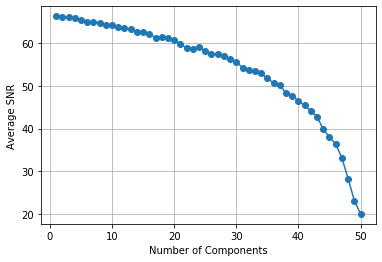

In [10]:
plt.plot(range(1,ComponentsNumbers+1),mean_SNR, marker='o')
plt.ylabel("Average SNR")
plt.xlabel("Number of Components")
plt.grid()
plt.show()

In [11]:
output_df = pd.DataFrame({'x': range(1,ComponentsNumbers+1),'y': mean_SNR})  
output_df.to_csv('knownFrequencySupport.dat')